### Dane:
https://www.kaggle.com/datasets/doctrinek/oxford-iiit-cats-extended-10k  

## Eksploracyjna analiza danych


In [3]:
rm -rf `find -type d -name .ipynb_checkpoints`

Liczba klas: 12
Liczba danych: 10239
Klasy: ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx']


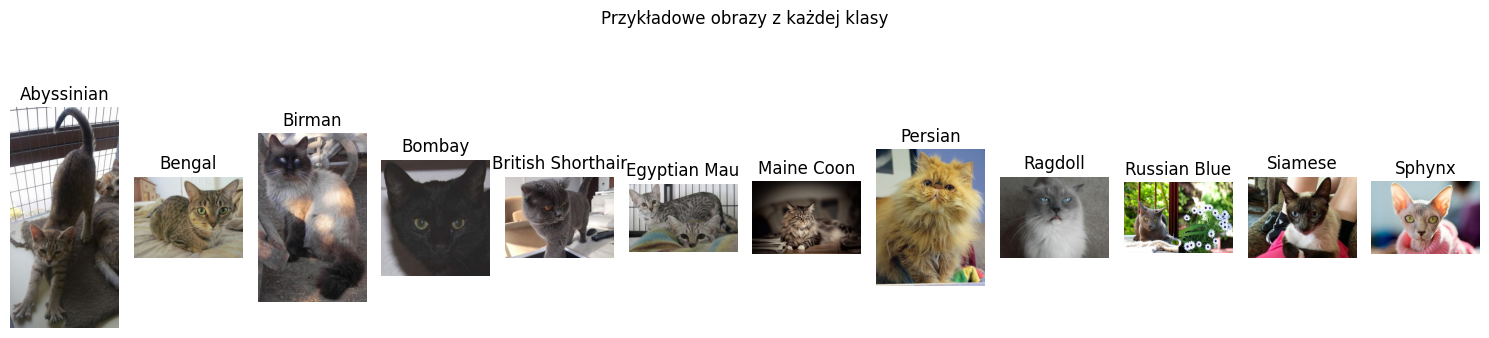

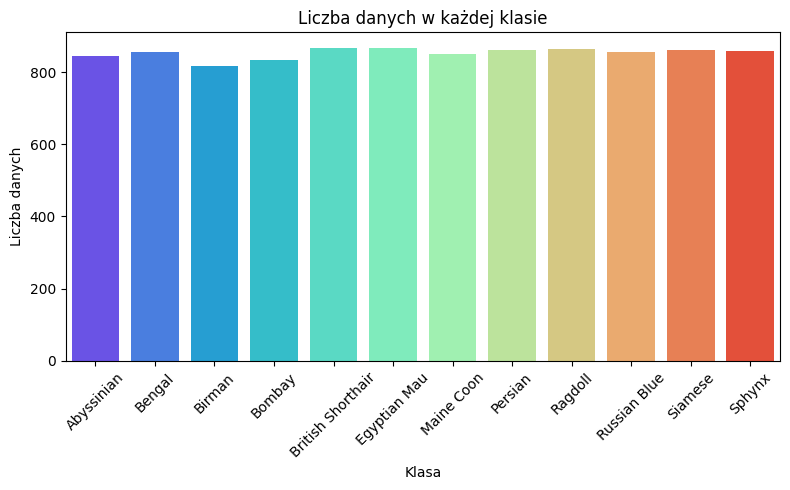

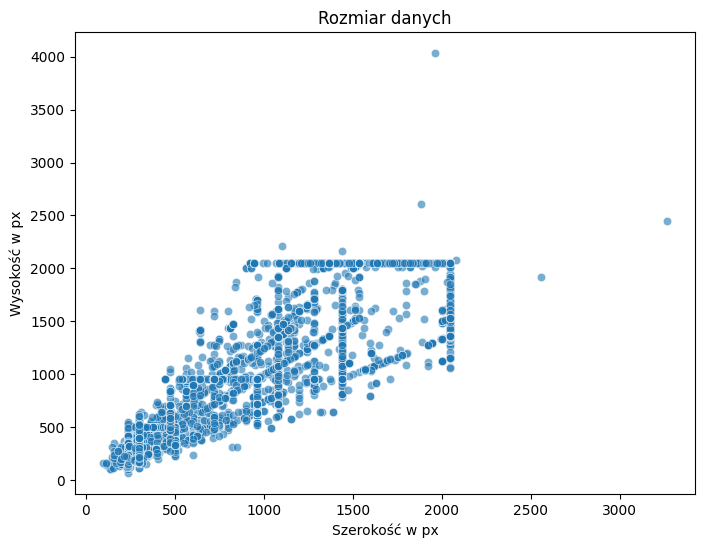

Średnia szerokość: 699.2915323762086
Średnia wysokość: 741.2788358238109


In [40]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

data_dir = 'data'
dataset = datasets.ImageFolder(data_dir)
num_classes = len(dataset.classes)
print("Liczba klas:",num_classes)
print("Liczba danych:",len(dataset))
print("Klasy:",dataset.classes)

# przykładowe obrazy
fig, axes = plt.subplots(1, min(num_classes,num_classes), figsize=(15, 4))
for i, cls in enumerate(dataset.classes):
    class_idx = dataset.class_to_idx[cls]

    for path, label in dataset.samples:
        if label == class_idx:
            img = Image.open(path)
            axes[i].imshow(img)
            axes[i].set_title(cls)
            axes[i].axis("off")
            break
plt.suptitle("Przykładowe obrazy z każdej klasy")
plt.tight_layout()
plt.show()

class_count = {cl: 0 for cl in dataset.classes}
for _, label in dataset.samples:
    class_count[dataset.classes[label]] += 1

# wykres rozkładu klas
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_count.keys()), y=list(class_count.values()), palette="rainbow", hue=list(class_count.keys()))
plt.title("Liczba danych w każdej klasie")
plt.xlabel("Klasa")
plt.ylabel("Liczba danych")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


widths, heights = [], []
for path, _ in dataset.samples:
    with Image.open(path) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)

# wykres rozkładu rozmiarów
plt.figure(figsize=(8, 6))
sns.scatterplot(x=widths, y=heights, alpha=0.6)
plt.title("Rozmiar danych")
plt.xlabel("Szerokość w px")
plt.ylabel("Wysokość w px")
plt.show()

print("Średnia szerokość:", np.mean(widths))
print("Średnia wysokość:", np.mean(heights))


## Baseline model - bez augmentacji

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from sklearn.metrics import f1_score
import wandb

wandb.init(project="CatBreedClassifier", config={
    "epochs": 100,
    "batch_size": 64,
    "learning_rate": 0.01,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "optimizer": "SGD",
    "architecture": "Custom-CNN"
})

config = wandb.config

# DANE
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  
    transforms.ToTensor()
])

data_dir = 'data'
dataset = datasets.ImageFolder(data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=config.batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False)
num_classes = len(dataset.classes)

#MODEL
class CatBreedClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CatBreedClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CatBreedClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=config.momentum, weight_decay=config.weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.3)

best_val_loss = float('inf')

# TRENING 
for epoch in range(config.epochs):
    model.train()
    running_loss = 0.0
    total_steps = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_steps += 1

    avg_train_loss = running_loss / total_steps

    # WALIDACJA
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')


    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'cat_breed_classifier_baseline.pth')

    # LOGI 
    wandb.log({
        "train/epoch": epoch + 1,
        "train/loss": avg_train_loss,
        "train/learning_rate": scheduler.get_last_lr()[0],
        "eval/loss": avg_val_loss,
        "eval/accuracy": val_accuracy,
        "eval/f1": val_f1,
    })

    print(f"Epoch {epoch+1}/{config.epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Acc: {val_accuracy:.4f} | "
          f"F1: {val_f1:.4f}")

wandb.finish()


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sarasatan52 (sarasatan52-politechnika-bydgoska) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/100 | Train Loss: 2.2826 | Val Loss: 2.2463 | Acc: 0.1962 | F1: 0.1393
Epoch 2/100 | Train Loss: 2.0938 | Val Loss: 2.0973 | Acc: 0.2855 | F1: 0.2503
Epoch 3/100 | Train Loss: 2.0643 | Val Loss: 2.0134 | Acc: 0.3065 | F1: 0.2505
Epoch 4/100 | Train Loss: 2.0310 | Val Loss: 1.9040 | Acc: 0.3572 | F1: 0.3168
Epoch 5/100 | Train Loss: 1.9869 | Val Loss: 1.9469 | Acc: 0.3446 | F1: 0.2831
Epoch 6/100 | Train Loss: 1.9668 | Val Loss: 1.9573 | Acc: 0.3065 | F1: 0.2568
Epoch 7/100 | Train Loss: 1.9308 | Val Loss: 1.8918 | Acc: 0.3812 | F1: 0.3271
Epoch 8/100 | Train Loss: 1.9337 | Val Loss: 1.9296 | Acc: 0.3587 | F1: 0.3191
Epoch 9/100 | Train Loss: 1.9318 | Val Loss: 1.8772 | Acc: 0.3509 | F1: 0.3248
Epoch 10/100 | Train Loss: 1.9048 | Val Loss: 1.9270 | Acc: 0.3441 | F1: 0.3245
Epoch 11/100 | Train Loss: 1.8680 | Val Loss: 1.7499 | Acc: 0.4085 | F1: 0.3629
Epoch 12/100 | Train Loss: 1.8232 | Val Loss: 1.8732 | Acc: 0.3694 | F1: 0.3440
Epoch 13/100 | Train Loss: 1.8160 | Val Loss: 1.7

eval/accuracy,▁▃▄▅▄▄▆▆▆▆▇▆▇▇▇▇▇▇██████████████████████
eval/f1,▁▂▃▃▄▃▃▃▅▆▆▅▆▆▆▆▆▇▇▇▇▇██▇███████████████
eval/loss,█▆▆▆▅▄▅▅▆▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇███
train/learning_rate,███████▃▃▃▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▇▇▇▆▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/accuracy,0.58858
eval/f1,0.57896
eval/loss,1.22882
train/epoch,100
train/learning_rate,0.0


### Trening sieci od podstaw (800MB... 60% acc), emisja wieksza o 100kg/year od transfer

In [48]:
pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: psutil
    Found existing installation: psutil 5.9.8
    Uninstalling psutil-5.9.8:
      Successfully uninstalled psutil-5.9.8
  Attempting uninstall: cffi
    Found existing installation: cffi 1.16.0
    Uninstalling cffi-1.16.0:
      Successfully uninstalled cffi-1.16.0

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from sklearn.metrics import f1_score
import wandb
from codecarbon import EmissionsTracker

wandb.init(project="CatBreedClassifier", config={
    "epochs": 150,
    "batch_size": 64,
    "learning_rate": 0.001,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "optimizer": "SGD",
    "architecture": "Custom-CNN"
})

config = wandb.config
tracker = EmissionsTracker(output_dir="carbon_logs", measure_power_secs=10)
tracker.start()

# Przygotowanie danych 
transform = transforms.Compose([
    # losowo kadruje i zmienia rozmiar obrazu do 224×224 pikseli
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  
    # losowo odbija obraz w poziomie
    transforms.RandomHorizontalFlip(),
    # losowo obraca obraz o max 30 stopni
    transforms.RandomRotation(10),
    # zniekształca obraz perspektywicznie
    transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    # zmienia jasność, kontrast, nasycenie i odcień
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # konwertuje obraz na tensor
    transforms.ToTensor(),
    # losowo wymazuje fragment obrazu
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    # normalizuje wartości pikseli do [-1, 1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


data_dir = 'data'
dataset = datasets.ImageFolder(data_dir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_data.dataset.transform = transform
test_data.dataset.transform = test_transform

train_loader = DataLoader(train_data, batch_size=config.batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False)
num_classes = len(dataset.classes)

#MODEL
class CatBreedClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CatBreedClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        return self.fc3(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CatBreedClassifier(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=config.momentum, weight_decay=config.weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.3,min_lr=1e-8)

best_val_loss = float('inf')

# TRENING 
for epoch in range(config.epochs):
    model.train()
    running_loss = 0.0
    total_steps = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_steps += 1

    avg_train_loss = running_loss / total_steps

    # WALIDACJA
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')


    scheduler.step(avg_val_loss)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'cat_breed_classifier.pth')

    # LOGI 
    wandb.log({
        "train/epoch": epoch + 1,
        "train/loss": avg_train_loss,
        "train/learning_rate": scheduler.get_last_lr()[0],
        "eval/loss": avg_val_loss,
        "eval/accuracy": val_accuracy,
        "eval/f1": val_f1,
    })

    print(f"Epoch {epoch+1}/{config.epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Acc: {val_accuracy:.4f} | "
          f"F1: {val_f1:.4f}")

tracker.stop()
wandb.finish()

eval/accuracy,▃▄▁▅▆▅▅▆▆▄▇▇▆▇▇▆▇▇▇█▇▇
eval/f1,▃▄▁▅▆▅▅▆▅▄▆▆▇▇█▆▇▇██▇▇
eval/loss,▅▄█▃▃▃▃▃▃▃▂▂▂▁▁▂▂▁▁▁▂▁
train/epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▁▂▁▁
eval/accuracy,0.44412
eval/f1,0.41652
eval/loss,1.64126
train/epoch,22
train/learning_rate,0.01


[codecarbon WARNING @ 18:41:26] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 18:41:26] [setup] RAM Tracking...
[codecarbon INFO @ 18:41:26] [setup] CPU Tracking...
[codecarbon INFO @ 18:41:26] Energy consumed for RAM : 0.125280 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:41:26] Energy consumed for RAM : 0.057027 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:41:27] Delta energy consumed for CPU with cpu_load : 0.000053 kWh, power : 20.026656936363633 W
[codecarbon INFO @ 18:41:27] Energy consumed for All CPU : 0.052539 kWh
[codecarbon INFO @ 18:41:27] Delta energy consumed for CPU with cpu_load : 0.000053 kWh, power : 20.02689406181818 W
[codecarbon INFO @ 18:41:27] Energy consumed for All CPU : 0.023632 kWh
[codecarbon INFO @ 18:41:27] Energy consumed for all GPUs : 0.224343 kWh. Total GPU Power : 52.81071166347768 W
[codecarbon INFO @ 18:41:27] 0.402161 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:41:27] Energy consum

Epoch 1/150 | Train Loss: 2.1890 | Val Loss: 1.8196 | Acc: 0.3797 | F1: 0.3441


[codecarbon INFO @ 18:42:31] Energy consumed for RAM : 0.000869 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:42:31] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.483030109090908 W
[codecarbon INFO @ 18:42:31] Energy consumed for All CPU : 0.000361 kWh
[codecarbon INFO @ 18:42:31] Energy consumed for all GPUs : 0.001597 kWh. Total GPU Power : 57.28025030556277 W
[codecarbon INFO @ 18:42:31] 0.002827 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:42:36] Energy consumed for RAM : 0.077237 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:42:36] Energy consumed for RAM : 0.126276 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:42:36] Energy consumed for RAM : 0.058022 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:42:37] Delta energy consumed for CPU with cpu_load : 0.000057 kWh, power : 21.476038646000003 W
[codecarbon INFO @ 18:42:37] Energy consumed for All CPU : 0.032162 kWh
[codecarbon INFO @ 18:42:37] Delta energy consumed for CPU with cpu_load 

Epoch 2/150 | Train Loss: 1.8520 | Val Loss: 1.6897 | Acc: 0.4065 | F1: 0.3710


[codecarbon INFO @ 18:43:32] Energy consumed for RAM : 0.026464 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:43:32] Delta energy consumed for CPU with cpu_load : 0.000058 kWh, power : 22.21342398363636 W
[codecarbon INFO @ 18:43:32] Energy consumed for All CPU : 0.010769 kWh
[codecarbon INFO @ 18:43:32] Energy consumed for all GPUs : 0.045587 kWh. Total GPU Power : 76.26566644317325 W
[codecarbon INFO @ 18:43:32] 0.082819 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:43:33] Energy consumed for RAM : 0.021631 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:43:33] Delta energy consumed for CPU with cpu_load : 0.000058 kWh, power : 21.845435816 W
[codecarbon INFO @ 18:43:33] Energy consumed for All CPU : 0.009004 kWh
[codecarbon INFO @ 18:43:33] Energy consumed for all GPUs : 0.040572 kWh. Total GPU Power : 89.16575334437945 W
[codecarbon INFO @ 18:43:33] 0.071207 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:43:33] 0.030128 g.CO2eq/s mean an estim

Epoch 3/150 | Train Loss: 1.7115 | Val Loss: 1.5980 | Acc: 0.4519 | F1: 0.4336


[codecarbon INFO @ 18:44:28] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 23.615893901818183 W
[codecarbon INFO @ 18:44:28] Energy consumed for All CPU : 0.053612 kWh
[codecarbon INFO @ 18:44:28] Energy consumed for all GPUs : 0.229177 kWh. Total GPU Power : 57.36738134621732 W
[codecarbon INFO @ 18:44:28] 0.410638 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:44:31] Energy consumed for RAM : 0.002575 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:44:31] Delta energy consumed for CPU with cpu_load : 0.000057 kWh, power : 21.603367136000006 W
[codecarbon INFO @ 18:44:31] Energy consumed for All CPU : 0.001078 kWh
[codecarbon INFO @ 18:44:31] Energy consumed for all GPUs : 0.004908 kWh. Total GPU Power : 82.0370117070223 W
[codecarbon INFO @ 18:44:31] 0.008561 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:44:32] Energy consumed for RAM : 0.027317 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:44:32] Delta energy consumed for 

Epoch 4/150 | Train Loss: 1.5806 | Val Loss: 1.5821 | Acc: 0.4588 | F1: 0.4340


[codecarbon INFO @ 18:45:24] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 23.698026690909103 W
[codecarbon INFO @ 18:45:24] Energy consumed for All CPU : 0.009668 kWh
[codecarbon INFO @ 18:45:24] Energy consumed for all GPUs : 0.043579 kWh. Total GPU Power : 59.33265597940518 W
[codecarbon INFO @ 18:45:24] 0.076452 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:45:27] Energy consumed for RAM : 0.060448 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:45:27] Energy consumed for RAM : 0.079663 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:45:27] Energy consumed for RAM : 0.128702 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:45:28] Delta energy consumed for CPU with cpu_load : 0.000057 kWh, power : 21.71517974545455 W
[codecarbon INFO @ 18:45:28] Energy consumed for All CPU : 0.025061 kWh
[codecarbon INFO @ 18:45:28] Delta energy consumed for CPU with cpu_load : 0.000057 kWh, power : 21.70116335818182 W
[codecarbon INFO @ 18:45:28] Delta energy con

Epoch 5/150 | Train Loss: 1.4511 | Val Loss: 1.5194 | Acc: 0.4636 | F1: 0.4526


[codecarbon INFO @ 18:46:21] Energy consumed for RAM : 0.004133 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:46:21] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.876807042000003 W
[codecarbon INFO @ 18:46:21] Energy consumed for All CPU : 0.001735 kWh
[codecarbon INFO @ 18:46:21] Energy consumed for all GPUs : 0.007930 kWh. Total GPU Power : 59.36082375649174 W
[codecarbon INFO @ 18:46:21] 0.013797 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:46:22] Energy consumed for RAM : 0.028883 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:46:22] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.613377976363633 W
[codecarbon INFO @ 18:46:22] Energy consumed for All CPU : 0.011787 kWh
[codecarbon INFO @ 18:46:22] Energy consumed for all GPUs : 0.050269 kWh. Total GPU Power : 63.38064304524446 W
[codecarbon INFO @ 18:46:22] 0.090939 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:46:24] Energy consumed for RAM :

Epoch 6/150 | Train Loss: 1.3185 | Val Loss: 1.5657 | Acc: 0.4744 | F1: 0.4529


[codecarbon INFO @ 18:47:17] Energy consumed for RAM : 0.062012 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:47:17] Energy consumed for RAM : 0.081227 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:47:17] Energy consumed for RAM : 0.130265 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:47:18] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.511287032727274 W
[codecarbon INFO @ 18:47:18] Energy consumed for All CPU : 0.025720 kWh
[codecarbon INFO @ 18:47:18] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.510261998181818 W
[codecarbon INFO @ 18:47:18] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.511287032727274 W
[codecarbon INFO @ 18:47:18] Energy consumed for All CPU : 0.033838 kWh
[codecarbon INFO @ 18:47:18] Energy consumed for All CPU : 0.054627 kWh
[codecarbon INFO @ 18:47:18] Energy consumed for all GPUs : 0.116172 kWh. Total GPU Power : 68.45966410617079 W
[codecarbon INFO @ 18:47:18] 0.203904 kWh of electrici

Epoch 7/150 | Train Loss: 1.1877 | Val Loss: 1.4333 | Acc: 0.5071 | F1: 0.5004


[codecarbon INFO @ 18:48:12] Energy consumed for All CPU : 0.002393 kWh
[codecarbon INFO @ 18:48:12] Energy consumed for all GPUs : 0.011046 kWh. Total GPU Power : 59.73560797913624 W
[codecarbon INFO @ 18:48:12] 0.019136 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:48:12] 0.029637 g.CO2eq/s mean an estimation of 934.6459011635508 kg.CO2eq/year
[codecarbon INFO @ 18:48:12] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.7718559 W
[codecarbon INFO @ 18:48:12] Energy consumed for All CPU : 0.012446 kWh
[codecarbon INFO @ 18:48:12] Energy consumed for all GPUs : 0.053366 kWh. Total GPU Power : 59.791047788221924 W
[codecarbon INFO @ 18:48:12] 0.096260 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:48:17] Energy consumed for RAM : 0.062864 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:48:17] Energy consumed for RAM : 0.082079 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:48:17] Energy consumed for RAM : 0.131117 kWh. RAM Powe

Epoch 8/150 | Train Loss: 1.0671 | Val Loss: 1.4947 | Acc: 0.4998 | F1: 0.4914


[codecarbon INFO @ 18:49:08] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.32535897454546 W
[codecarbon INFO @ 18:49:08] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.502740367272725 W
[codecarbon INFO @ 18:49:08] Energy consumed for All CPU : 0.026383 kWh
[codecarbon INFO @ 18:49:08] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.49611266909091 W
[codecarbon INFO @ 18:49:08] Energy consumed for All CPU : 0.034500 kWh
[codecarbon INFO @ 18:49:08] Energy consumed for All CPU : 0.055289 kWh
[codecarbon INFO @ 18:49:08] Energy consumed for all GPUs : 0.119252 kWh. Total GPU Power : 60.20023407713309 W
[codecarbon INFO @ 18:49:08] 0.209210 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:08] Energy consumed for all GPUs : 0.152444 kWh. Total GPU Power : 60.197405308388255 W
[codecarbon INFO @ 18:49:08] 0.269735 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:49:08] Energy consu

Epoch 9/150 | Train Loss: 0.9133 | Val Loss: 1.4485 | Acc: 0.5071 | F1: 0.4857


[codecarbon INFO @ 18:50:04] Energy consumed for RAM : 0.027186 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:50:04] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.45253871272728 W
[codecarbon INFO @ 18:50:04] Energy consumed for All CPU : 0.011345 kWh
[codecarbon INFO @ 18:50:04] Energy consumed for all GPUs : 0.051429 kWh. Total GPU Power : 59.80678699159482 W
[codecarbon INFO @ 18:50:04] 0.089961 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:50:07] Energy consumed for RAM : 0.064428 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:50:07] Energy consumed for RAM : 0.083643 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:50:07] Energy consumed for RAM : 0.132681 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:50:08] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.059598223636367 W
[codecarbon INFO @ 18:50:08] Energy consumed for All CPU : 0.026738 kWh
[codecarbon INFO @ 18:50:08] Delta energy consumed for CPU with cpu_load :

Epoch 10/150 | Train Loss: 0.8050 | Val Loss: 1.4520 | Acc: 0.5232 | F1: 0.5176


[codecarbon INFO @ 18:51:01] Energy consumed for RAM : 0.008106 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:51:01] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.866983134545453 W
[codecarbon INFO @ 18:51:01] Energy consumed for All CPU : 0.003406 kWh
[codecarbon INFO @ 18:51:01] Energy consumed for all GPUs : 0.015834 kWh. Total GPU Power : 77.33543003667828 W
[codecarbon INFO @ 18:51:01] 0.027346 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:51:02] Energy consumed for RAM : 0.032865 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:51:02] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.448694552727275 W
[codecarbon INFO @ 18:51:02] Energy consumed for All CPU : 0.013466 kWh
[codecarbon INFO @ 18:51:02] Energy consumed for all GPUs : 0.058183 kWh. Total GPU Power : 84.91963692082962 W
[codecarbon INFO @ 18:51:02] 0.104514 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:51:04] Energy consumed for RAM :

Epoch 11/150 | Train Loss: 0.6318 | Val Loss: 1.8563 | Acc: 0.4534 | F1: 0.4595


[codecarbon INFO @ 18:51:54] Energy consumed for RAM : 0.028751 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:51:54] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.13410509818182 W
[codecarbon INFO @ 18:51:54] Energy consumed for All CPU : 0.012005 kWh
[codecarbon INFO @ 18:51:54] Energy consumed for all GPUs : 0.054553 kWh. Total GPU Power : 59.965984911448096 W
[codecarbon INFO @ 18:51:54] 0.095309 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:51:57] Energy consumed for RAM : 0.065992 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:51:57] Energy consumed for RAM : 0.085207 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:51:57] Energy consumed for RAM : 0.134244 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:51:58] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.926250705454546 W
[codecarbon INFO @ 18:51:58] Energy consumed for All CPU : 0.027397 kWh
[codecarbon INFO @ 18:51:58] Delta energy consumed for CPU with cpu_load 

Epoch 12/150 | Train Loss: 0.4084 | Val Loss: 1.4178 | Acc: 0.5608 | F1: 0.5567


[codecarbon INFO @ 18:52:52] Energy consumed for all GPUs : 0.018926 kWh. Total GPU Power : 61.18419020029829 W
[codecarbon INFO @ 18:52:52] 0.032660 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:52:52] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.11778021090909 W
[codecarbon INFO @ 18:52:52] Energy consumed for All CPU : 0.014126 kWh
[codecarbon INFO @ 18:52:52] Energy consumed for all GPUs : 0.061247 kWh. Total GPU Power : 60.29549380200556 W
[codecarbon INFO @ 18:52:52] 0.109803 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:52:54] Energy consumed for RAM : 0.029604 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:52:54] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.151684152 W
[codecarbon INFO @ 18:52:54] Energy consumed for All CPU : 0.012364 kWh
[codecarbon INFO @ 18:52:54] Energy consumed for all GPUs : 0.056235 kWh. Total GPU Power : 71.20522321665278 W
[codecarbon INFO @ 18:52:54] 0.098203

Epoch 13/150 | Train Loss: 0.3026 | Val Loss: 1.5135 | Acc: 0.5530 | F1: 0.5443


[codecarbon INFO @ 18:53:48] Energy consumed for all GPUs : 0.127140 kWh. Total GPU Power : 59.25582366312908 W
[codecarbon INFO @ 18:53:48] Energy consumed for all GPUs : 0.160332 kWh. Total GPU Power : 59.226083113015555 W
[codecarbon INFO @ 18:53:48] 0.222757 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:53:48] Energy consumed for all GPUs : 0.244892 kWh. Total GPU Power : 59.234215983020896 W
[codecarbon INFO @ 18:53:48] 0.283281 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:53:48] 0.437666 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:53:50] Energy consumed for RAM : 0.156259 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:53:50] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.137925600000006 W
[codecarbon INFO @ 18:53:50] Energy consumed for All CPU : 0.065591 kWh
[codecarbon INFO @ 18:53:50] Energy consumed for all GPUs : 0.279221 kWh. Total GPU Power : 72.70335033312281 W
[codecarbon INFO @ 18:5

Epoch 14/150 | Train Loss: 0.2645 | Val Loss: 1.4892 | Acc: 0.5530 | F1: 0.5492


[codecarbon INFO @ 18:54:44] Energy consumed for RAM : 0.031168 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:54:44] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.75781596545455 W
[codecarbon INFO @ 18:54:44] Energy consumed for All CPU : 0.013023 kWh
[codecarbon INFO @ 18:54:44] Energy consumed for all GPUs : 0.059332 kWh. Total GPU Power : 65.11589188517283 W
[codecarbon INFO @ 18:54:44] 0.103524 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:54:47] Energy consumed for RAM : 0.068408 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:54:47] Energy consumed for RAM : 0.087622 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:54:47] Energy consumed for RAM : 0.136659 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:54:48] Delta energy consumed for CPU with cpu_load : 0.000059 kWh, power : 22.37344373818182 W
[codecarbon INFO @ 18:54:48] Energy consumed for All CPU : 0.028418 kWh
[codecarbon INFO @ 18:54:48] Delta energy consumed for CPU with cpu_load : 

Epoch 15/150 | Train Loss: 0.2356 | Val Loss: 1.4623 | Acc: 0.5593 | F1: 0.5575


[codecarbon INFO @ 18:55:40] Energy consumed for RAM : 0.157824 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:55:40] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.9113662909091 W
[codecarbon INFO @ 18:55:40] Energy consumed for All CPU : 0.066249 kWh
[codecarbon INFO @ 18:55:40] Energy consumed for all GPUs : 0.282341 kWh. Total GPU Power : 69.01188011864475 W
[codecarbon INFO @ 18:55:40] 0.506414 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:55:41] Energy consumed for RAM : 0.012079 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:55:41] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.912822081818184 W
[codecarbon INFO @ 18:55:41] Energy consumed for All CPU : 0.005078 kWh
[codecarbon INFO @ 18:55:41] Energy consumed for all GPUs : 0.023723 kWh. Total GPU Power : 74.07170025019569 W
[codecarbon INFO @ 18:55:41] 0.040879 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:55:42] Energy consumed for RAM : 0

Epoch 16/150 | Train Loss: 0.2031 | Val Loss: 1.5410 | Acc: 0.5554 | F1: 0.5543


[codecarbon INFO @ 18:56:34] Energy consumed for RAM : 0.032732 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:56:34] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.19668993454546 W
[codecarbon INFO @ 18:56:34] Energy consumed for All CPU : 0.013684 kWh
[codecarbon INFO @ 18:56:34] Energy consumed for all GPUs : 0.062447 kWh. Total GPU Power : 59.9456122452824 W
[codecarbon INFO @ 18:56:34] 0.108863 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:56:37] Energy consumed for RAM : 0.069972 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:56:37] Energy consumed for RAM : 0.089186 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:56:37] Energy consumed for RAM : 0.138223 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:56:38] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.452485270909097 W
[codecarbon INFO @ 18:56:38] Energy consumed for All CPU : 0.029080 kWh
[codecarbon INFO @ 18:56:38] Delta energy consumed for CPU with cpu_load : 

Epoch 17/150 | Train Loss: 0.1596 | Val Loss: 1.5135 | Acc: 0.5676 | F1: 0.5641


[codecarbon INFO @ 18:57:30] Energy consumed for RAM : 0.159388 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:57:30] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.25789759636364 W
[codecarbon INFO @ 18:57:30] Energy consumed for All CPU : 0.066909 kWh
[codecarbon INFO @ 18:57:30] Energy consumed for all GPUs : 0.285471 kWh. Total GPU Power : 73.87816418830698 W
[codecarbon INFO @ 18:57:30] 0.511768 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:57:31] Energy consumed for RAM : 0.013642 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:57:31] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.264705850909095 W
[codecarbon INFO @ 18:57:31] Energy consumed for All CPU : 0.005739 kWh
[codecarbon INFO @ 18:57:31] Energy consumed for all GPUs : 0.026858 kWh. Total GPU Power : 80.70176447721838 W
[codecarbon INFO @ 18:57:31] 0.046240 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:57:31] 0.030286 g.CO2eq/s mean an

Epoch 18/150 | Train Loss: 0.1509 | Val Loss: 1.5199 | Acc: 0.5681 | F1: 0.5647


[codecarbon INFO @ 18:58:27] Energy consumed for RAM : 0.071536 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:58:27] Energy consumed for RAM : 0.090750 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:58:27] Energy consumed for RAM : 0.139787 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:58:28] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.778658116363644 W
[codecarbon INFO @ 18:58:28] Energy consumed for All CPU : 0.029739 kWh
[codecarbon INFO @ 18:58:28] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.77705142 W
[codecarbon INFO @ 18:58:28] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.777449449090913 W
[codecarbon INFO @ 18:58:28] Energy consumed for All CPU : 0.037855 kWh
[codecarbon INFO @ 18:58:28] Energy consumed for All CPU : 0.058644 kWh
[codecarbon INFO @ 18:58:28] Energy consumed for all GPUs : 0.135082 kWh. Total GPU Power : 77.58884702203673 W
[codecarbon INFO @ 18:58:28] 0.236358 kWh of electricity used

Epoch 19/150 | Train Loss: 0.1477 | Val Loss: 1.5061 | Acc: 0.5715 | F1: 0.5681


[codecarbon INFO @ 18:59:20] Energy consumed for RAM : 0.160952 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:59:20] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 24.92772023818182 W
[codecarbon INFO @ 18:59:20] Energy consumed for All CPU : 0.067571 kWh
[codecarbon INFO @ 18:59:20] Energy consumed for all GPUs : 0.288551 kWh. Total GPU Power : 59.9086656312607 W
[codecarbon INFO @ 18:59:20] 0.517073 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:59:21] Energy consumed for RAM : 0.015207 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 18:59:21] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.58067118909091 W
[codecarbon INFO @ 18:59:21] Energy consumed for All CPU : 0.006401 kWh
[codecarbon INFO @ 18:59:21] Energy consumed for all GPUs : 0.029938 kWh. Total GPU Power : 66.98073008066487 W
[codecarbon INFO @ 18:59:21] 0.051545 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:59:22] Energy consumed for RAM : 0.

Epoch 20/150 | Train Loss: 0.1314 | Val Loss: 1.5353 | Acc: 0.5652 | F1: 0.5596


[codecarbon INFO @ 19:00:14] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.23566477818182 W
[codecarbon INFO @ 19:00:14] Energy consumed for All CPU : 0.015008 kWh
[codecarbon INFO @ 19:00:14] Energy consumed for all GPUs : 0.068684 kWh. Total GPU Power : 59.634787602764646 W
[codecarbon INFO @ 19:00:14] 0.119553 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:00:17] Energy consumed for RAM : 0.073100 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:00:17] Energy consumed for RAM : 0.092314 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:00:17] Energy consumed for RAM : 0.141350 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:00:18] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.903384045454548 W
[codecarbon INFO @ 19:00:18] Energy consumed for All CPU : 0.030401 kWh
[codecarbon INFO @ 19:00:18] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.93623306363637 W
[codecarbon INFO @ 19:00:18] Energy consumed

Epoch 21/150 | Train Loss: 0.1278 | Val Loss: 1.5309 | Acc: 0.5764 | F1: 0.5714


[codecarbon INFO @ 19:01:10] Energy consumed for RAM : 0.162516 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:01:10] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 24.095053083636365 W
[codecarbon INFO @ 19:01:10] Energy consumed for All CPU : 0.068229 kWh
[codecarbon INFO @ 19:01:10] Energy consumed for all GPUs : 0.291685 kWh. Total GPU Power : 60.45950220163666 W
[codecarbon INFO @ 19:01:10] 0.522431 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:01:11] Energy consumed for RAM : 0.016771 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:01:11] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.759137852727278 W
[codecarbon INFO @ 19:01:11] Energy consumed for All CPU : 0.007059 kWh
[codecarbon INFO @ 19:01:11] Energy consumed for all GPUs : 0.033063 kWh. Total GPU Power : 64.44043308168487 W
[codecarbon INFO @ 19:01:11] 0.056893 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:01:12] Energy consumed for RAM :

Epoch 22/150 | Train Loss: 0.1271 | Val Loss: 1.5284 | Acc: 0.5715 | F1: 0.5673


[codecarbon INFO @ 19:02:07] Energy consumed for RAM : 0.074664 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:02:07] Energy consumed for RAM : 0.093878 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:02:07] Energy consumed for RAM : 0.142914 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:02:08] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.754471400000007 W
[codecarbon INFO @ 19:02:08] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.77736422545455 W
[codecarbon INFO @ 19:02:08] Energy consumed for All CPU : 0.031059 kWh
[codecarbon INFO @ 19:02:08] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.771664656363637 W
[codecarbon INFO @ 19:02:08] Energy consumed for All CPU : 0.039175 kWh
[codecarbon INFO @ 19:02:08] Energy consumed for All CPU : 0.059964 kWh
[codecarbon INFO @ 19:02:08] Energy consumed for all GPUs : 0.141310 kWh. Total GPU Power : 70.21844915193863 W
[codecarbon INFO @ 19:02:08] 0.247034 kWh of electricit

Epoch 23/150 | Train Loss: 0.1247 | Val Loss: 1.5227 | Acc: 0.5695 | F1: 0.5651


[codecarbon INFO @ 19:03:01] Energy consumed for RAM : 0.018335 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:03:01] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.16466662727273 W
[codecarbon INFO @ 19:03:01] Energy consumed for All CPU : 0.007719 kWh
[codecarbon INFO @ 19:03:01] Energy consumed for all GPUs : 0.036166 kWh. Total GPU Power : 60.76573661587505 W
[codecarbon INFO @ 19:03:01] 0.062220 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:03:02] Energy consumed for RAM : 0.043105 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:03:02] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.903290394545458 W
[codecarbon INFO @ 19:03:02] Energy consumed for All CPU : 0.017783 kWh
[codecarbon INFO @ 19:03:02] Energy consumed for all GPUs : 0.078508 kWh. Total GPU Power : 65.21952488334075 W
[codecarbon INFO @ 19:03:02] 0.139396 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:03:04] Energy consumed for RAM : 

Epoch 24/150 | Train Loss: 0.1237 | Val Loss: 1.5297 | Acc: 0.5720 | F1: 0.5674


[codecarbon INFO @ 19:03:57] Energy consumed for RAM : 0.076228 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:03:57] Energy consumed for RAM : 0.095442 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:03:57] Energy consumed for RAM : 0.144478 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:03:58] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.149961852727277 W
[codecarbon INFO @ 19:03:58] Energy consumed for All CPU : 0.031719 kWh
[codecarbon INFO @ 19:03:58] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.18881840363637 W
[codecarbon INFO @ 19:03:58] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.06863091454545 W
[codecarbon INFO @ 19:03:58] Energy consumed for All CPU : 0.039834 kWh
[codecarbon INFO @ 19:03:58] Energy consumed for All CPU : 0.060623 kWh
[codecarbon INFO @ 19:03:58] Energy consumed for all GPUs : 0.144394 kWh. Total GPU Power : 59.81215336443369 W
[codecarbon INFO @ 19:03:58] 0.252341 kWh of electricity

Epoch 25/150 | Train Loss: 0.1168 | Val Loss: 1.5151 | Acc: 0.5715 | F1: 0.5671


[codecarbon INFO @ 19:04:51] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.24389046727273 W
[codecarbon INFO @ 19:04:51] Energy consumed for All CPU : 0.008381 kWh
[codecarbon INFO @ 19:04:51] Energy consumed for all GPUs : 0.039290 kWh. Total GPU Power : 59.750146821065265 W
[codecarbon INFO @ 19:04:51] 0.067571 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:04:52] Energy consumed for RAM : 0.044669 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:04:52] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.10650038 W
[codecarbon INFO @ 19:04:52] Energy consumed for All CPU : 0.018443 kWh
[codecarbon INFO @ 19:04:52] Energy consumed for all GPUs : 0.081621 kWh. Total GPU Power : 60.67037894289554 W
[codecarbon INFO @ 19:04:52] 0.144734 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:04:54] Energy consumed for RAM : 0.039843 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:04:54] Delta energy consumed for CPU wi

Epoch 26/150 | Train Loss: 0.1213 | Val Loss: 1.5214 | Acc: 0.5691 | F1: 0.5652


[codecarbon INFO @ 19:05:47] Energy consumed for RAM : 0.077792 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:05:47] Energy consumed for RAM : 0.097006 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:05:47] Energy consumed for RAM : 0.146041 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:05:48] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.406380887272732 W
[codecarbon INFO @ 19:05:48] Energy consumed for All CPU : 0.032378 kWh
[codecarbon INFO @ 19:05:48] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.41995548909091 W
[codecarbon INFO @ 19:05:48] Energy consumed for All CPU : 0.040493 kWh
[codecarbon INFO @ 19:05:48] Energy consumed for all GPUs : 0.147526 kWh. Total GPU Power : 60.13548941684543 W
[codecarbon INFO @ 19:05:48] 0.257696 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:05:48] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.378444707272727 W
[codecarbon INFO @ 19:05:48] Energy consumed

Epoch 27/150 | Train Loss: 0.1213 | Val Loss: 1.5311 | Acc: 0.5730 | F1: 0.5689


[codecarbon INFO @ 19:06:42] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.403682785454546 W
[codecarbon INFO @ 19:06:42] Energy consumed for All CPU : 0.019101 kWh
[codecarbon INFO @ 19:06:42] Energy consumed for all GPUs : 0.084754 kWh. Total GPU Power : 60.031585207052984 W
[codecarbon INFO @ 19:06:42] 0.150089 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:06:44] Energy consumed for RAM : 0.041407 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:06:44] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.54588718909091 W
[codecarbon INFO @ 19:06:44] Energy consumed for All CPU : 0.017343 kWh
[codecarbon INFO @ 19:06:44] Energy consumed for all GPUs : 0.079741 kWh. Total GPU Power : 70.86765626519042 W
[codecarbon INFO @ 19:06:44] 0.138491 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:06:47] Energy consumed for RAM : 0.078645 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:06:47] Energy consumed for RAM :

Epoch 28/150 | Train Loss: 0.1226 | Val Loss: 1.5251 | Acc: 0.5764 | F1: 0.5711


[codecarbon INFO @ 19:07:37] Energy consumed for RAM : 0.079356 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:07:37] Energy consumed for RAM : 0.098570 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:07:37] Energy consumed for RAM : 0.147605 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:07:38] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 24.894168860000004 W
[codecarbon INFO @ 19:07:38] Energy consumed for All CPU : 0.033036 kWh
[codecarbon INFO @ 19:07:38] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 24.870167463636367 W
[codecarbon INFO @ 19:07:38] Energy consumed for all GPUs : 0.150660 kWh. Total GPU Power : 60.446630403248825 W
[codecarbon INFO @ 19:07:38] Energy consumed for All CPU : 0.041152 kWh
[codecarbon INFO @ 19:07:38] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 24.88506611272728 W
[codecarbon INFO @ 19:07:38] 0.263052 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:07:38] Energy consume

Epoch 29/150 | Train Loss: 0.1197 | Val Loss: 1.5287 | Acc: 0.5725 | F1: 0.5683


[codecarbon INFO @ 19:08:32] Energy consumed for RAM : 0.047798 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:08:32] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.52195757818182 W
[codecarbon INFO @ 19:08:32] Energy consumed for All CPU : 0.019760 kWh
[codecarbon INFO @ 19:08:32] Energy consumed for all GPUs : 0.087888 kWh. Total GPU Power : 59.970163595668446 W
[codecarbon INFO @ 19:08:32] 0.155447 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:08:32] 0.029913 g.CO2eq/s mean an estimation of 943.3209683621872 kg.CO2eq/year
[codecarbon INFO @ 19:08:34] Energy consumed for RAM : 0.042971 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:08:34] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.807819130909095 W
[codecarbon INFO @ 19:08:34] Energy consumed for All CPU : 0.018003 kWh
[codecarbon INFO @ 19:08:34] Energy consumed for all GPUs : 0.082883 kWh. Total GPU Power : 73.65133864420285 W
[codecarbon INFO @ 19:08:34] 0.1438

Epoch 30/150 | Train Loss: 0.1175 | Val Loss: 1.5303 | Acc: 0.5759 | F1: 0.5713


[codecarbon INFO @ 19:09:27] Energy consumed for RAM : 0.080920 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:09:27] Energy consumed for RAM : 0.100134 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:09:27] Energy consumed for RAM : 0.149169 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:09:28] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.133495896363637 W
[codecarbon INFO @ 19:09:28] Energy consumed for All CPU : 0.033695 kWh
[codecarbon INFO @ 19:09:28] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.11065973818182 W
[codecarbon INFO @ 19:09:28] Energy consumed for All CPU : 0.041811 kWh
[codecarbon INFO @ 19:09:28] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.133069787272728 W
[codecarbon INFO @ 19:09:28] Energy consumed for All CPU : 0.062599 kWh
[codecarbon INFO @ 19:09:28] Energy consumed for all GPUs : 0.153827 kWh. Total GPU Power : 72.61567713504589 W
[codecarbon INFO @ 19:09:28] 0.268441 kWh of electricit

Epoch 31/150 | Train Loss: 0.1190 | Val Loss: 1.5324 | Acc: 0.5720 | F1: 0.5677


[codecarbon INFO @ 19:10:22] Energy consumed for RAM : 0.049363 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:10:22] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.186475590909087 W
[codecarbon INFO @ 19:10:22] Energy consumed for All CPU : 0.020419 kWh
[codecarbon INFO @ 19:10:22] Energy consumed for all GPUs : 0.091015 kWh. Total GPU Power : 59.14289839795707 W
[codecarbon INFO @ 19:10:22] 0.160796 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:10:24] Energy consumed for RAM : 0.044535 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:10:24] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.55188392181818 W
[codecarbon INFO @ 19:10:24] Energy consumed for All CPU : 0.018661 kWh
[codecarbon INFO @ 19:10:24] Energy consumed for all GPUs : 0.086016 kWh. Total GPU Power : 75.16578484662305 W
[codecarbon INFO @ 19:10:24] 0.149212 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:10:27] Energy consumed for RAM : 

Epoch 32/150 | Train Loss: 0.1211 | Val Loss: 1.5298 | Acc: 0.5715 | F1: 0.5670


[codecarbon INFO @ 19:11:18] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.366547769090914 W
[codecarbon INFO @ 19:11:18] Energy consumed for All CPU : 0.034355 kWh
[codecarbon INFO @ 19:11:18] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.30606367818182 W
[codecarbon INFO @ 19:11:18] Energy consumed for All CPU : 0.042471 kWh
[codecarbon INFO @ 19:11:18] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.296480216363637 W
[codecarbon INFO @ 19:11:18] Energy consumed for All CPU : 0.063259 kWh
[codecarbon INFO @ 19:11:18] Energy consumed for all GPUs : 0.156923 kWh. Total GPU Power : 60.81472932746754 W
[codecarbon INFO @ 19:11:18] 0.273762 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:18] Energy consumed for all GPUs : 0.190116 kWh. Total GPU Power : 60.843883975707534 W
[codecarbon INFO @ 19:11:18] 0.334284 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:11:18] Energy cons

Epoch 33/150 | Train Loss: 0.1186 | Val Loss: 1.5209 | Acc: 0.5749 | F1: 0.5705


[codecarbon INFO @ 19:12:12] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.530353056363637 W
[codecarbon INFO @ 19:12:12] Energy consumed for All CPU : 0.021078 kWh
[codecarbon INFO @ 19:12:12] Energy consumed for all GPUs : 0.094150 kWh. Total GPU Power : 59.719099550633146 W
[codecarbon INFO @ 19:12:12] 0.166155 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:12:14] Energy consumed for RAM : 0.046100 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:12:14] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.559963123636365 W
[codecarbon INFO @ 19:12:14] Energy consumed for All CPU : 0.019318 kWh
[codecarbon INFO @ 19:12:14] Energy consumed for all GPUs : 0.089140 kWh. Total GPU Power : 72.08571163286435 W
[codecarbon INFO @ 19:12:14] 0.154558 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:12:17] Energy consumed for RAM : 0.083337 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:12:17] Energy consumed for RAM 

Epoch 34/150 | Train Loss: 0.1180 | Val Loss: 1.5186 | Acc: 0.5739 | F1: 0.5697


[codecarbon INFO @ 19:13:08] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.005214312727276 W
[codecarbon INFO @ 19:13:08] Energy consumed for All CPU : 0.035015 kWh
[codecarbon INFO @ 19:13:08] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.02118186727273 W
[codecarbon INFO @ 19:13:08] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.01273171818182 W
[codecarbon INFO @ 19:13:08] Energy consumed for All CPU : 0.043130 kWh
[codecarbon INFO @ 19:13:08] Energy consumed for All CPU : 0.063918 kWh
[codecarbon INFO @ 19:13:08] Energy consumed for all GPUs : 0.160060 kWh. Total GPU Power : 60.11186788093819 W
[codecarbon INFO @ 19:13:08] 0.279122 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:13:08] Energy consumed for all GPUs : 0.193252 kWh. Total GPU Power : 59.96236279245082 W
[codecarbon INFO @ 19:13:08] 0.339645 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:13:08] Energy consum

Epoch 35/150 | Train Loss: 0.1197 | Val Loss: 1.5273 | Acc: 0.5695 | F1: 0.5660


[codecarbon INFO @ 19:14:04] Energy consumed for RAM : 0.047664 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:14:04] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.348763034545456 W
[codecarbon INFO @ 19:14:04] Energy consumed for All CPU : 0.019982 kWh
[codecarbon INFO @ 19:14:04] Energy consumed for all GPUs : 0.092251 kWh. Total GPU Power : 64.44960067913982 W
[codecarbon INFO @ 19:14:04] 0.159898 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:14:07] Energy consumed for RAM : 0.084900 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:14:07] Energy consumed for RAM : 0.104116 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:14:07] Energy consumed for RAM : 0.153149 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:14:08] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.961023367272727 W
[codecarbon INFO @ 19:14:08] Energy consumed for All CPU : 0.035376 kWh
[codecarbon INFO @ 19:14:08] Delta energy consumed for CPU with cpu_load 

Epoch 36/150 | Train Loss: 0.1166 | Val Loss: 1.5316 | Acc: 0.5749 | F1: 0.5699


[codecarbon INFO @ 19:14:58] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.062954221818185 W
[codecarbon INFO @ 19:14:58] Energy consumed for All CPU : 0.035679 kWh
[codecarbon INFO @ 19:14:58] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.038987467272726 W
[codecarbon INFO @ 19:14:58] Energy consumed for All CPU : 0.043795 kWh
[codecarbon INFO @ 19:14:58] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.035119218181823 W
[codecarbon INFO @ 19:14:58] Energy consumed for All CPU : 0.064583 kWh
[codecarbon INFO @ 19:14:58] Energy consumed for all GPUs : 0.163181 kWh. Total GPU Power : 61.17651579637128 W
[codecarbon INFO @ 19:14:58] 0.284472 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:14:58] Energy consumed for all GPUs : 0.196374 kWh. Total GPU Power : 61.185628937695725 W
[codecarbon INFO @ 19:14:58] 0.344995 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:14:58] Energy con

Epoch 37/150 | Train Loss: 0.1170 | Val Loss: 1.5293 | Acc: 0.5695 | F1: 0.5650


[codecarbon INFO @ 19:15:54] Energy consumed for RAM : 0.049229 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:15:54] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.70816111454546 W
[codecarbon INFO @ 19:15:54] Energy consumed for All CPU : 0.020643 kWh
[codecarbon INFO @ 19:15:54] Energy consumed for all GPUs : 0.095365 kWh. Total GPU Power : 63.96924142417869 W
[codecarbon INFO @ 19:15:54] 0.165237 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:15:57] Energy consumed for RAM : 0.086465 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:15:57] Energy consumed for RAM : 0.105680 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:15:57] Energy consumed for RAM : 0.154714 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:15:58] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.257645923636368 W
[codecarbon INFO @ 19:15:58] Energy consumed for All CPU : 0.036039 kWh
[codecarbon INFO @ 19:15:58] Delta energy consumed for CPU with cpu_load :

Epoch 38/150 | Train Loss: 0.1180 | Val Loss: 1.5211 | Acc: 0.5710 | F1: 0.5671


[codecarbon INFO @ 19:16:50] Energy consumed for RAM : 0.175882 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:16:51] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.844112220000007 W
[codecarbon INFO @ 19:16:51] Energy consumed for All CPU : 0.073867 kWh
[codecarbon INFO @ 19:16:51] Energy consumed for all GPUs : 0.318383 kWh. Total GPU Power : 70.21190595014781 W
[codecarbon INFO @ 19:16:51] 0.568132 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:16:51] Energy consumed for RAM : 0.030138 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:16:51] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.41308659272727 W
[codecarbon INFO @ 19:16:51] Energy consumed for All CPU : 0.012703 kWh
[codecarbon INFO @ 19:16:51] Energy consumed for all GPUs : 0.059773 kWh. Total GPU Power : 78.03603985027289 W
[codecarbon INFO @ 19:16:51] 0.102614 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:16:52] Energy consumed for RAM : 

Epoch 39/150 | Train Loss: 0.1163 | Val Loss: 1.5260 | Acc: 0.5744 | F1: 0.5705


[codecarbon INFO @ 19:17:44] Energy consumed for RAM : 0.050793 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:17:44] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.57291086727273 W
[codecarbon INFO @ 19:17:44] Energy consumed for All CPU : 0.021299 kWh
[codecarbon INFO @ 19:17:44] Energy consumed for all GPUs : 0.098493 kWh. Total GPU Power : 59.76763076600076 W
[codecarbon INFO @ 19:17:44] 0.170584 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:17:47] Energy consumed for RAM : 0.088029 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:17:47] Energy consumed for RAM : 0.107245 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:17:47] Energy consumed for RAM : 0.156278 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:17:48] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.72161055454546 W
[codecarbon INFO @ 19:17:48] Energy consumed for All CPU : 0.036697 kWh
[codecarbon INFO @ 19:17:48] Delta energy consumed for CPU with cpu_load : 

Epoch 40/150 | Train Loss: 0.1169 | Val Loss: 1.5232 | Acc: 0.5735 | F1: 0.5691


[codecarbon INFO @ 19:18:40] Energy consumed for RAM : 0.177446 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:18:41] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.04860321454546 W
[codecarbon INFO @ 19:18:41] Energy consumed for All CPU : 0.074527 kWh
[codecarbon INFO @ 19:18:41] Energy consumed for all GPUs : 0.321484 kWh. Total GPU Power : 60.78403312865395 W
[codecarbon INFO @ 19:18:41] 0.573457 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:18:41] 0.029876 g.CO2eq/s mean an estimation of 942.1849696717429 kg.CO2eq/year
[codecarbon INFO @ 19:18:41] Energy consumed for RAM : 0.031702 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:18:41] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.366703781818185 W
[codecarbon INFO @ 19:18:41] Energy consumed for All CPU : 0.013360 kWh
[codecarbon INFO @ 19:18:41] Energy consumed for all GPUs : 0.062869 kWh. Total GPU Power : 67.48047706539901 W
[codecarbon INFO @ 19:18:41] 0.10793

Epoch 41/150 | Train Loss: 0.1187 | Val Loss: 1.5256 | Acc: 0.5744 | F1: 0.5700


[codecarbon INFO @ 19:19:34] Energy consumed for RAM : 0.052357 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:19:34] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.12874023090909 W
[codecarbon INFO @ 19:19:34] Energy consumed for All CPU : 0.021959 kWh
[codecarbon INFO @ 19:19:34] Energy consumed for all GPUs : 0.101621 kWh. Total GPU Power : 60.149403378281185 W
[codecarbon INFO @ 19:19:34] 0.175937 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:19:34] 0.029876 g.CO2eq/s mean an estimation of 942.174692311564 kg.CO2eq/year
[codecarbon INFO @ 19:19:37] Energy consumed for RAM : 0.089593 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:19:37] Energy consumed for RAM : 0.108809 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:19:37] Energy consumed for RAM : 0.157842 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:19:38] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.84235728727273 W
[codecarbon INFO @ 19:19:38] Energy consumed 

Epoch 42/150 | Train Loss: 0.1185 | Val Loss: 1.5297 | Acc: 0.5725 | F1: 0.5680


[codecarbon INFO @ 19:20:30] Energy consumed for RAM : 0.179011 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:20:31] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.61120877818182 W
[codecarbon INFO @ 19:20:31] Energy consumed for All CPU : 0.075188 kWh
[codecarbon INFO @ 19:20:31] Energy consumed for all GPUs : 0.324633 kWh. Total GPU Power : 65.64315290220448 W
[codecarbon INFO @ 19:20:31] 0.578832 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:20:31] Energy consumed for RAM : 0.033266 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:20:31] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.138986894545454 W
[codecarbon INFO @ 19:20:31] Energy consumed for All CPU : 0.014021 kWh
[codecarbon INFO @ 19:20:31] Energy consumed for all GPUs : 0.066021 kWh. Total GPU Power : 72.08273129379687 W
[codecarbon INFO @ 19:20:31] 0.113307 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:20:32] Energy consumed for RAM : 

Epoch 43/150 | Train Loss: 0.1190 | Val Loss: 1.5238 | Acc: 0.5730 | F1: 0.5691


[codecarbon INFO @ 19:21:24] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.23697799454545 W
[codecarbon INFO @ 19:21:24] Energy consumed for All CPU : 0.022617 kWh
[codecarbon INFO @ 19:21:24] Energy consumed for all GPUs : 0.104756 kWh. Total GPU Power : 60.46192261881486 W
[codecarbon INFO @ 19:21:24] 0.181295 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:21:27] Energy consumed for RAM : 0.091157 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:21:27] Energy consumed for RAM : 0.110373 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:21:27] Energy consumed for RAM : 0.159406 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:21:28] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.928180894545456 W
[codecarbon INFO @ 19:21:28] Energy consumed for All CPU : 0.038016 kWh
[codecarbon INFO @ 19:21:28] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.948842063636366 W
[codecarbon INFO @ 19:21:28] Energy consumed

Epoch 44/150 | Train Loss: 0.1174 | Val Loss: 1.5294 | Acc: 0.5715 | F1: 0.5672


[codecarbon INFO @ 19:22:20] Energy consumed for RAM : 0.180575 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:22:21] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.770477607272724 W
[codecarbon INFO @ 19:22:21] Energy consumed for All CPU : 0.075844 kWh
[codecarbon INFO @ 19:22:21] Energy consumed for all GPUs : 0.327763 kWh. Total GPU Power : 63.09879067928681 W
[codecarbon INFO @ 19:22:21] 0.584183 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:22:21] Energy consumed for RAM : 0.034830 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:22:21] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.49431272181819 W
[codecarbon INFO @ 19:22:21] Energy consumed for All CPU : 0.014676 kWh
[codecarbon INFO @ 19:22:21] Energy consumed for all GPUs : 0.069157 kWh. Total GPU Power : 72.51097241094018 W
[codecarbon INFO @ 19:22:21] 0.118663 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:22:22] Energy consumed for RAM : 

Epoch 45/150 | Train Loss: 0.1183 | Val Loss: 1.5193 | Acc: 0.5725 | F1: 0.5687


[codecarbon INFO @ 19:23:14] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.377918354545457 W
[codecarbon INFO @ 19:23:14] Energy consumed for All CPU : 0.023277 kWh
[codecarbon INFO @ 19:23:14] Energy consumed for all GPUs : 0.107891 kWh. Total GPU Power : 59.77323244120258 W
[codecarbon INFO @ 19:23:14] 0.186652 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:23:17] Energy consumed for RAM : 0.092721 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:23:17] Energy consumed for RAM : 0.111937 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:23:17] Energy consumed for RAM : 0.160969 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:23:18] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.892602176363642 W
[codecarbon INFO @ 19:23:18] Energy consumed for All CPU : 0.038675 kWh
[codecarbon INFO @ 19:23:18] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.871040745454547 W
[codecarbon INFO @ 19:23:18] Energy consume

Epoch 46/150 | Train Loss: 0.1234 | Val Loss: 1.5249 | Acc: 0.5681 | F1: 0.5644


[codecarbon INFO @ 19:24:10] Energy consumed for RAM : 0.182139 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:24:11] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.968361392727275 W
[codecarbon INFO @ 19:24:11] Energy consumed for All CPU : 0.076502 kWh
[codecarbon INFO @ 19:24:11] Energy consumed for all GPUs : 0.330903 kWh. Total GPU Power : 64.58031210381634 W
[codecarbon INFO @ 19:24:11] 0.589544 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:24:11] Energy consumed for RAM : 0.036395 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:24:11] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 24.003372979999998 W
[codecarbon INFO @ 19:24:11] Energy consumed for All CPU : 0.015335 kWh
[codecarbon INFO @ 19:24:11] Energy consumed for all GPUs : 0.072291 kWh. Total GPU Power : 71.37770423680742 W
[codecarbon INFO @ 19:24:11] 0.124021 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:24:11] 0.030188 g.CO2eq/s mean a

Epoch 47/150 | Train Loss: 0.1214 | Val Loss: 1.5253 | Acc: 0.5705 | F1: 0.5663


[codecarbon INFO @ 19:25:04] Energy consumed for RAM : 0.057049 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:25:04] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.81033991454546 W
[codecarbon INFO @ 19:25:04] Energy consumed for All CPU : 0.023935 kWh
[codecarbon INFO @ 19:25:04] Energy consumed for all GPUs : 0.111025 kWh. Total GPU Power : 60.50232106823191 W
[codecarbon INFO @ 19:25:04] 0.192008 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:25:07] Energy consumed for RAM : 0.094285 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:25:07] Energy consumed for RAM : 0.113501 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:25:07] Energy consumed for RAM : 0.162533 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:25:08] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.587823294545455 W
[codecarbon INFO @ 19:25:08] Energy consumed for All CPU : 0.039334 kWh
[codecarbon INFO @ 19:25:08] Delta energy consumed for CPU with cpu_load :

Epoch 48/150 | Train Loss: 0.1176 | Val Loss: 1.5281 | Acc: 0.5754 | F1: 0.5708


[codecarbon INFO @ 19:26:00] Energy consumed for RAM : 0.183703 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:26:01] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.216846665454547 W
[codecarbon INFO @ 19:26:01] Energy consumed for All CPU : 0.077160 kWh
[codecarbon INFO @ 19:26:01] Energy consumed for all GPUs : 0.334060 kWh. Total GPU Power : 73.9907251364835 W
[codecarbon INFO @ 19:26:01] 0.594923 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:26:01] Energy consumed for RAM : 0.037959 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:26:01] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.184488458181818 W
[codecarbon INFO @ 19:26:01] Energy consumed for All CPU : 0.015993 kWh
[codecarbon INFO @ 19:26:01] Energy consumed for all GPUs : 0.075454 kWh. Total GPU Power : 83.26490915236202 W
[codecarbon INFO @ 19:26:01] 0.129406 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:26:02] Energy consumed for RAM : 

Epoch 49/150 | Train Loss: 0.1186 | Val Loss: 1.5211 | Acc: 0.5691 | F1: 0.5652


[codecarbon INFO @ 19:26:54] Energy consumed for RAM : 0.058613 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:26:54] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.841360590909098 W
[codecarbon INFO @ 19:26:54] Energy consumed for All CPU : 0.024594 kWh
[codecarbon INFO @ 19:26:54] Energy consumed for all GPUs : 0.114163 kWh. Total GPU Power : 60.1815896620719 W
[codecarbon INFO @ 19:26:54] 0.197370 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:26:57] Energy consumed for RAM : 0.095849 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:26:57] Energy consumed for RAM : 0.115064 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:26:57] Energy consumed for RAM : 0.164096 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:26:58] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.469907520000003 W
[codecarbon INFO @ 19:26:58] Energy consumed for All CPU : 0.039995 kWh
[codecarbon INFO @ 19:26:58] Delta energy consumed for CPU with cpu_load :

Epoch 50/150 | Train Loss: 0.1196 | Val Loss: 1.5289 | Acc: 0.5671 | F1: 0.5630


[codecarbon INFO @ 19:27:50] Energy consumed for RAM : 0.185267 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:27:51] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.137027201818185 W
[codecarbon INFO @ 19:27:51] Energy consumed for All CPU : 0.077822 kWh
[codecarbon INFO @ 19:27:51] Energy consumed for all GPUs : 0.337197 kWh. Total GPU Power : 74.13963904745346 W
[codecarbon INFO @ 19:27:51] 0.600286 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:27:51] Energy consumed for RAM : 0.039524 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:27:51] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.645280423636372 W
[codecarbon INFO @ 19:27:51] Energy consumed for All CPU : 0.016652 kWh
[codecarbon INFO @ 19:27:51] Energy consumed for all GPUs : 0.078582 kWh. Total GPU Power : 79.95910291225752 W
[codecarbon INFO @ 19:27:51] 0.134757 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:27:52] Energy consumed for RAM :

Epoch 51/150 | Train Loss: 0.1175 | Val Loss: 1.5260 | Acc: 0.5715 | F1: 0.5677


[codecarbon INFO @ 19:28:44] Energy consumed for RAM : 0.060177 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:28:44] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 24.061397469090913 W
[codecarbon INFO @ 19:28:44] Energy consumed for All CPU : 0.025252 kWh
[codecarbon INFO @ 19:28:44] Energy consumed for all GPUs : 0.117307 kWh. Total GPU Power : 64.93789819455588 W
[codecarbon INFO @ 19:28:44] 0.202736 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:28:47] Energy consumed for RAM : 0.097413 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:28:47] Energy consumed for RAM : 0.116628 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:28:47] Energy consumed for RAM : 0.165660 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:28:48] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.808963572727276 W
[codecarbon INFO @ 19:28:48] Energy consumed for All CPU : 0.040654 kWh
[codecarbon INFO @ 19:28:48] Delta energy consumed for CPU with cpu_load 

Epoch 52/150 | Train Loss: 0.1244 | Val Loss: 1.5275 | Acc: 0.5730 | F1: 0.5691


[codecarbon INFO @ 19:29:37] Energy consumed for RAM : 0.098124 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:29:37] Energy consumed for RAM : 0.117339 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:29:37] Energy consumed for RAM : 0.166371 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:29:38] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.143441420000002 W
[codecarbon INFO @ 19:29:38] Energy consumed for All CPU : 0.040955 kWh
[codecarbon INFO @ 19:29:38] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.143261452727273 W
[codecarbon INFO @ 19:29:38] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.14873991636364 W
[codecarbon INFO @ 19:29:38] Energy consumed for All CPU : 0.049070 kWh
[codecarbon INFO @ 19:29:38] Energy consumed for All CPU : 0.069858 kWh
[codecarbon INFO @ 19:29:38] Energy consumed for all GPUs : 0.188244 kWh. Total GPU Power : 59.26628130220842 W
[codecarbon INFO @ 19:29:38] 0.327323 kWh of electricit

Epoch 53/150 | Train Loss: 0.1165 | Val Loss: 1.5274 | Acc: 0.5691 | F1: 0.5656


[codecarbon INFO @ 19:30:32] Energy consumed for RAM : 0.066570 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:30:32] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 24.95870190363636 W
[codecarbon INFO @ 19:30:32] Energy consumed for All CPU : 0.027683 kWh
[codecarbon INFO @ 19:30:32] Energy consumed for all GPUs : 0.125480 kWh. Total GPU Power : 59.75702539783325 W
[codecarbon INFO @ 19:30:32] 0.219733 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:30:34] Energy consumed for RAM : 0.061741 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:30:34] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.237066865454548 W
[codecarbon INFO @ 19:30:34] Energy consumed for All CPU : 0.025913 kWh
[codecarbon INFO @ 19:30:34] Energy consumed for all GPUs : 0.120473 kWh. Total GPU Power : 72.67559284479202 W
[codecarbon INFO @ 19:30:34] 0.208127 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:30:37] Energy consumed for RAM : 

Epoch 54/150 | Train Loss: 0.1169 | Val Loss: 1.5232 | Acc: 0.5691 | F1: 0.5657


[codecarbon INFO @ 19:31:27] Energy consumed for RAM : 0.099687 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:31:27] Energy consumed for RAM : 0.118903 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:31:27] Energy consumed for RAM : 0.167936 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:31:28] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.136218870909094 W
[codecarbon INFO @ 19:31:28] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.00688403 W
[codecarbon INFO @ 19:31:28] Energy consumed for All CPU : 0.049731 kWh
[codecarbon INFO @ 19:31:28] Energy consumed for All CPU : 0.041615 kWh
[codecarbon INFO @ 19:31:28] Energy consumed for all GPUs : 0.224581 kWh. Total GPU Power : 59.64926431131763 W
[codecarbon INFO @ 19:31:28] 0.393215 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:31:28] Energy consumed for all GPUs : 0.191388 kWh. Total GPU Power : 59.61241376378272 W
[codecarbon INFO @ 19:31:28] 0.332691 kWh of electricity

Epoch 55/150 | Train Loss: 0.1184 | Val Loss: 1.5203 | Acc: 0.5671 | F1: 0.5638


[codecarbon INFO @ 19:32:21] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.418375692727274 W
[codecarbon INFO @ 19:32:21] Energy consumed for All CPU : 0.018277 kWh
[codecarbon INFO @ 19:32:22] Energy consumed for all GPUs : 0.086296 kWh. Total GPU Power : 61.15606099028177 W
[codecarbon INFO @ 19:32:22] 0.147936 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:32:22] Energy consumed for RAM : 0.068134 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:32:22] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 24.90604836909091 W
[codecarbon INFO @ 19:32:22] Energy consumed for All CPU : 0.028345 kWh
[codecarbon INFO @ 19:32:22] Energy consumed for all GPUs : 0.128624 kWh. Total GPU Power : 60.669496994165534 W
[codecarbon INFO @ 19:32:22] 0.225102 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:32:24] Energy consumed for RAM : 0.063306 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:32:24] Delta energy consumed for

Epoch 56/150 | Train Loss: 0.1175 | Val Loss: 1.5336 | Acc: 0.5759 | F1: 0.5701


[codecarbon INFO @ 19:33:17] Energy consumed for RAM : 0.101250 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:33:17] Energy consumed for RAM : 0.120467 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:33:17] Energy consumed for RAM : 0.169499 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:33:18] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.74958816545455 W
[codecarbon INFO @ 19:33:18] Energy consumed for All CPU : 0.042275 kWh
[codecarbon INFO @ 19:33:18] Energy consumed for all GPUs : 0.194541 kWh. Total GPU Power : 65.25091363958153 W
[codecarbon INFO @ 19:33:18] 0.338067 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:33:18] 0.030034 g.CO2eq/s mean an estimation of 947.1534022392073 kg.CO2eq/year
[codecarbon INFO @ 19:33:18] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.757180598181822 W
[codecarbon INFO @ 19:33:18] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.76371759272728 W
[codecarbon INF

Epoch 57/150 | Train Loss: 0.1180 | Val Loss: 1.5285 | Acc: 0.5686 | F1: 0.5651


[codecarbon INFO @ 19:34:11] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.542930981818188 W
[codecarbon INFO @ 19:34:11] Energy consumed for All CPU : 0.018937 kWh
[codecarbon INFO @ 19:34:11] Energy consumed for all GPUs : 0.089436 kWh. Total GPU Power : 60.16542862419549 W
[codecarbon INFO @ 19:34:11] 0.153299 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:34:12] Energy consumed for RAM : 0.069698 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:34:12] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.6855692509091 W
[codecarbon INFO @ 19:34:12] Energy consumed for All CPU : 0.029002 kWh
[codecarbon INFO @ 19:34:12] Energy consumed for all GPUs : 0.131773 kWh. Total GPU Power : 62.691171462161535 W
[codecarbon INFO @ 19:34:12] 0.230474 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:34:14] Energy consumed for RAM : 0.064870 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:34:14] Delta energy consumed for 

Epoch 58/150 | Train Loss: 0.1199 | Val Loss: 1.5258 | Acc: 0.5715 | F1: 0.5677


[codecarbon INFO @ 19:35:07] Energy consumed for RAM : 0.102814 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:35:07] Energy consumed for RAM : 0.122030 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:35:07] Energy consumed for RAM : 0.171062 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:35:08] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.91849576363637 W
[codecarbon INFO @ 19:35:08] Energy consumed for All CPU : 0.042933 kWh
[codecarbon INFO @ 19:35:08] Energy consumed for all GPUs : 0.197712 kWh. Total GPU Power : 72.94505575810582 W
[codecarbon INFO @ 19:35:08] 0.343459 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:35:08] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.958582500000002 W
[codecarbon INFO @ 19:35:08] Energy consumed for All CPU : 0.051049 kWh
[codecarbon INFO @ 19:35:08] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.97121224909091 W
[codecarbon INFO @ 19:35:08] Energy consumed 

Epoch 59/150 | Train Loss: 0.1207 | Val Loss: 1.5280 | Acc: 0.5730 | F1: 0.5681


[codecarbon INFO @ 19:36:01] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 24.906116605454546 W
[codecarbon INFO @ 19:36:01] Energy consumed for All CPU : 0.080765 kWh
[codecarbon INFO @ 19:36:01] Energy consumed for all GPUs : 0.351205 kWh. Total GPU Power : 60.49614607890972 W
[codecarbon INFO @ 19:36:01] 0.624205 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:36:01] 0.029925 g.CO2eq/s mean an estimation of 943.7237293473012 kg.CO2eq/year
[codecarbon INFO @ 19:36:01] Energy consumed for RAM : 0.046490 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:36:01] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.18870030909091 W
[codecarbon INFO @ 19:36:01] Energy consumed for All CPU : 0.019595 kWh
[codecarbon INFO @ 19:36:01] Energy consumed for all GPUs : 0.092574 kWh. Total GPU Power : 60.26692535530739 W
[codecarbon INFO @ 19:36:01] 0.158659 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:36:02] Energy consu

Epoch 60/150 | Train Loss: 0.1199 | Val Loss: 1.5305 | Acc: 0.5691 | F1: 0.5649


[codecarbon INFO @ 19:36:54] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.28237656181819 W
[codecarbon INFO @ 19:36:54] Energy consumed for All CPU : 0.028194 kWh
[codecarbon INFO @ 19:36:54] Energy consumed for all GPUs : 0.131351 kWh. Total GPU Power : 61.117502778451886 W
[codecarbon INFO @ 19:36:54] 0.226690 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:36:54] 0.030033 g.CO2eq/s mean an estimation of 947.1153974277565 kg.CO2eq/year
[codecarbon INFO @ 19:36:57] Energy consumed for RAM : 0.104378 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:36:57] Energy consumed for RAM : 0.123595 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:36:57] Energy consumed for RAM : 0.172626 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:36:58] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.22879653818182 W
[codecarbon INFO @ 19:36:58] Energy consumed for All CPU : 0.043592 kWh
[codecarbon INFO @ 19:36:58] Energy consumed for all GPUs : 

Epoch 61/150 | Train Loss: 0.1165 | Val Loss: 1.5230 | Acc: 0.5730 | F1: 0.5690


[codecarbon INFO @ 19:37:51] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 24.875338405454546 W
[codecarbon INFO @ 19:37:51] Energy consumed for All CPU : 0.020257 kWh
[codecarbon INFO @ 19:37:51] Energy consumed for all GPUs : 0.095721 kWh. Total GPU Power : 60.16517657489796 W
[codecarbon INFO @ 19:37:51] 0.164032 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:37:52] Energy consumed for RAM : 0.072826 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:37:52] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.997957827272728 W
[codecarbon INFO @ 19:37:52] Energy consumed for All CPU : 0.030320 kWh
[codecarbon INFO @ 19:37:52] Energy consumed for all GPUs : 0.138053 kWh. Total GPU Power : 61.11206494705314 W
[codecarbon INFO @ 19:37:52] 0.241200 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:37:52] 0.030016 g.CO2eq/s mean an estimation of 946.575442668547 kg.CO2eq/year
[codecarbon INFO @ 19:37:54] Energy consu

Epoch 62/150 | Train Loss: 0.1224 | Val Loss: 1.5267 | Acc: 0.5735 | F1: 0.5690


[codecarbon INFO @ 19:38:48] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.37525189818182 W
[codecarbon INFO @ 19:38:48] Energy consumed for All CPU : 0.044254 kWh
[codecarbon INFO @ 19:38:48] Energy consumed for all GPUs : 0.203970 kWh. Total GPU Power : 60.70772513191833 W
[codecarbon INFO @ 19:38:48] 0.354165 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:38:48] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.332218578181827 W
[codecarbon INFO @ 19:38:48] Energy consumed for All CPU : 0.052369 kWh
[codecarbon INFO @ 19:38:48] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.32322316 W
[codecarbon INFO @ 19:38:48] Energy consumed for All CPU : 0.073156 kWh
[codecarbon INFO @ 19:38:48] Energy consumed for all GPUs : 0.237163 kWh. Total GPU Power : 60.726602808956876 W
[codecarbon INFO @ 19:38:48] 0.414691 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:38:48] Energy consumed fo

Epoch 63/150 | Train Loss: 0.1182 | Val Loss: 1.5260 | Acc: 0.5676 | F1: 0.5643


[codecarbon INFO @ 19:39:44] Energy consumed for RAM : 0.069562 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:39:44] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.58389872 W
[codecarbon INFO @ 19:39:44] Energy consumed for All CPU : 0.029210 kWh
[codecarbon INFO @ 19:39:44] Energy consumed for all GPUs : 0.136167 kWh. Total GPU Power : 61.61052630030292 W
[codecarbon INFO @ 19:39:44] 0.234939 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:39:47] Energy consumed for RAM : 0.106795 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:39:47] Energy consumed for RAM : 0.126012 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:39:47] Energy consumed for RAM : 0.175044 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:39:48] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.66036116727273 W
[codecarbon INFO @ 19:39:48] Energy consumed for All CPU : 0.044611 kWh
[codecarbon INFO @ 19:39:48] Energy consumed for all GPUs : 0.205707 kWh. Total G

KeyboardInterrupt: 

[codecarbon INFO @ 19:40:37] Energy consumed for RAM : 0.107505 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:40:37] Energy consumed for RAM : 0.126723 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:40:37] Energy consumed for RAM : 0.175755 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 19:40:38] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.889711589090908 W
[codecarbon INFO @ 19:40:38] Energy consumed for All CPU : 0.044908 kWh
[codecarbon INFO @ 19:40:38] Energy consumed for all GPUs : 0.207101 kWh. Total GPU Power : 59.147566754110585 W
[codecarbon INFO @ 19:40:38] 0.359514 kWh of electricity used since the beginning.
[codecarbon INFO @ 19:40:38] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.93856610909091 W
[codecarbon INFO @ 19:40:38] Energy consumed for All CPU : 0.053024 kWh
[codecarbon INFO @ 19:40:38] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.88603194727273 W
[codecarbon INFO @ 19:40:38] Energy consumed

## Transfer learning - MobileNetv2 (8.8 MB! 86% acc)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score
import wandb
from codecarbon import EmissionsTracker

wandb.init(project="CatBreedClassifier", config={
    "epochs": 50,
    "batch_size": 64,
    "learning_rate": 3e-4,
    "weight_decay": 1e-4,
    "optimizer": "AdamW",
    "architecture": "MobileNetV2-TransferLearning"
})

config = wandb.config
tracker = EmissionsTracker(output_dir="carbon_logs", measure_power_secs=10)
tracker.start()

transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # standard ImageNet mean/std
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_dir = 'data'
dataset = datasets.ImageFolder(data_dir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_data.dataset.transform = transform
test_data.dataset.transform = test_transform

train_loader = DataLoader(train_data, batch_size=config.batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False)
num_classes = len(dataset.classes)

#  MODEL: MobileNetV2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

for param in model.features.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.last_channel, num_classes)
)

model = model.to(device)


criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
optimizer = optim.AdamW(model.classifier.parameters(),
                        lr=config.learning_rate,
                        weight_decay=config.weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)


best_val_loss = float('inf')

# TRENING
for epoch in range(config.epochs):
    model.train()
    running_loss = 0.0
    total_steps = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_steps += 1

    avg_train_loss = running_loss / total_steps

    # WALIDACJA
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    scheduler.step(avg_val_loss)
    emissions = tracker._prepare_emissions_data()  
    emissions_kg = emissions.emissions if emissions else 0.0
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'mobilenetv2_catbreed.pth')

    
    wandb.log({
        "train/epoch": epoch + 1,
        "train/loss": avg_train_loss,
        "train/learning_rate": scheduler.get_last_lr()[0],
        "eval/loss": avg_val_loss,
        "eval/accuracy": val_accuracy,
        "eval/f1": val_f1,
        "carbon/emissions_kg": emissions_kg
    })

    print(f"Epoch {epoch+1}/{config.epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Acc: {val_accuracy:.4f} | "
          f"F1: {val_f1:.4f}")


tracker.stop()
wandb.finish()


carbon/emissions_kg,▁▂▂▃▃▃▄▄▅▆▆▇▇▇█
eval/accuracy,▁▄▄▇▇▇▆▇█▇▇████
eval/f1,▁▄▄▇▇▇▆▇██▇████
eval/loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
carbon/emissions_kg,0.02156
eval/accuracy,0.84822
eval/f1,0.84734
eval/loss,0.99919


[codecarbon WARNING @ 21:13:02] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 21:13:02] [setup] RAM Tracking...
[codecarbon INFO @ 21:13:02] [setup] CPU Tracking...
[codecarbon WARNING @ 21:13:03] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 21:13:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) Silver 4210R CPU @ 2.40GHz
[codecarbon WARNING @ 21:13:03] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 21:13:03] [setup] GPU Tracking...
[codecarbon INFO @ 21:13:03] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 21:13:03] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: cpu_load
                GPU Tracking Method: pynvml
            
[codecarbon I

Epoch 1/50 | Train Loss: 1.7232 | Val Loss: 1.2435 | Acc: 0.7980 | F1: 0.7963


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:14:05] Energy consumed for RAM : 0.013224 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:14:06] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.953455120000005 W
[codecarbon INFO @ 21:14:06] Energy consumed for All CPU : 0.005542 kWh
[codecarbon INFO @ 21:14:06] Energy consumed for all GPUs : 0.018580 kWh. Total GPU Power : 69.16151031135608 W
[codecarbon INFO @ 21:14:06] 0.037346 kWh of electricity us

Epoch 2/50 | Train Loss: 1.1751 | Val Loss: 1.0637 | Acc: 0.8316 | F1: 0.8306


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:14:55] Energy consumed for RAM : 0.013935 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:14:56] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.88414253454545 W
[codecarbon INFO @ 21:14:56] Energy consumed for All CPU : 0.005842 kWh
[codecarbon INFO @ 21:14:56] Energy consumed for all GPUs : 0.019565 kWh. Total GPU Power : 57.50088294539821 W
[codecarbon INFO @ 21:14:56] 0.039343 kWh of electricity use

Epoch 3/50 | Train Loss: 1.0614 | Val Loss: 1.0120 | Acc: 0.8326 | F1: 0.8316


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:15:48] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 24.951975925454555 W
[codecarbon INFO @ 21:15:48] Energy consumed for All CPU : 0.000963 kWh
[codecarbon INFO @ 21:15:48] Energy consumed for all GPUs : 0.003212 kWh. Total GPU Power : 57.40266754648711 W
[codecarbon INFO @ 21:15:48] 0.006465 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:15:48] 0.025900 g.CO2eq/s mean an estimati

Epoch 4/50 | Train Loss: 1.0163 | Val Loss: 0.9921 | Acc: 0.8433 | F1: 0.8416


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:16:45] Energy consumed for RAM : 0.015499 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:16:46] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.121240238181823 W
[codecarbon INFO @ 21:16:46] Energy consumed for All CPU : 0.006503 kWh
[codecarbon INFO @ 21:16:46] Energy consumed for all GPUs : 0.021756 kWh. Total GPU Power : 68.8010121608843 W
[codecarbon INFO @ 21:16:46] 0.043757 kWh of electricity use

Epoch 5/50 | Train Loss: 0.9944 | Val Loss: 0.9708 | Acc: 0.8516 | F1: 0.8505


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:17:35] Energy consumed for RAM : 0.016209 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:17:36] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 24.06675993090909 W
[codecarbon INFO @ 21:17:36] Energy consumed for All CPU : 0.006803 kWh
[codecarbon INFO @ 21:17:36] Energy consumed for all GPUs : 0.022753 kWh. Total GPU Power : 58.065300254045916 W
[codecarbon INFO @ 21:17:36] 0.045765 kWh of electricity us

Epoch 6/50 | Train Loss: 0.9802 | Val Loss: 0.9574 | Acc: 0.8531 | F1: 0.8526


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:18:28] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.702477107272728 W
[codecarbon INFO @ 21:18:28] Energy consumed for All CPU : 0.001922 kWh
[codecarbon INFO @ 21:18:28] Energy consumed for all GPUs : 0.006389 kWh. Total GPU Power : 57.31160737017192 W
[codecarbon INFO @ 21:18:28] 0.012875 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:18:28] 0.025828 g.CO2eq/s mean an estimati

Epoch 7/50 | Train Loss: 0.9652 | Val Loss: 0.9482 | Acc: 0.8609 | F1: 0.8602


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:19:25] Energy consumed for RAM : 0.017772 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:19:26] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.69311266 W
[codecarbon INFO @ 21:19:26] Energy consumed for All CPU : 0.007460 kWh
[codecarbon INFO @ 21:19:26] Energy consumed for all GPUs : 0.024961 kWh. Total GPU Power : 68.42213035355537 W
[codecarbon INFO @ 21:19:26] 0.050193 kWh of electricity used sinc

Epoch 8/50 | Train Loss: 0.9553 | Val Loss: 0.9439 | Acc: 0.8565 | F1: 0.8556


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:20:18] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.243167243636364 W
[codecarbon INFO @ 21:20:18] Energy consumed for All CPU : 0.002580 kWh
[codecarbon INFO @ 21:20:18] Energy consumed for all GPUs : 0.008603 kWh. Total GPU Power : 56.98923806015214 W
[codecarbon INFO @ 21:20:18] 0.017309 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:20:25] Energy consumed for RAM : 0.018624 

Epoch 9/50 | Train Loss: 0.9517 | Val Loss: 0.9408 | Acc: 0.8614 | F1: 0.8605


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:21:15] Energy consumed for RAM : 0.019335 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:21:16] Delta energy consumed for CPU with cpu_load : 0.000058 kWh, power : 22.192420683636367 W
[codecarbon INFO @ 21:21:16] Energy consumed for All CPU : 0.008118 kWh
[codecarbon INFO @ 21:21:16] Energy consumed for all GPUs : 0.027176 kWh. Total GPU Power : 69.70064944889015 W
[codecarbon INFO @ 21:21:16] 0.054628 kWh of electricity us

Epoch 10/50 | Train Loss: 0.9370 | Val Loss: 0.9385 | Acc: 0.8624 | F1: 0.8612


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:22:05] Energy consumed for RAM : 0.020046 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:22:06] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.62636636727273 W
[codecarbon INFO @ 21:22:06] Energy consumed for All CPU : 0.008419 kWh
[codecarbon INFO @ 21:22:06] Energy consumed for all GPUs : 0.028192 kWh. Total GPU Power : 62.37268141605841 W
[codecarbon INFO @ 21:22:06] 0.056656 kWh of electricity use

Epoch 11/50 | Train Loss: 0.9359 | Val Loss: 0.9365 | Acc: 0.8609 | F1: 0.8600


[codecarbon INFO @ 21:22:58] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.199420452727274 W
[codecarbon INFO @ 21:22:58] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 21:22:58] Energy consumed for all GPUs : 0.011876 kWh. Total GPU Power : 56.687483369356606 W
[codecarbon INFO @ 21:22:58] 0.023818 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:23:05] Energy consumed for RAM : 0.020899 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:23:06] Delta energy consumed for CPU with cpu_load : 0.000056 kWh, power : 21.26100256727273 W
[codecarbon INFO @ 21:23:06] Energy consumed for All CPU : 0.008776 kWh
[codecarbon INFO @ 21:23:06] Energy consumed for all GPUs : 0.029457 kWh. Total GPU Power : 79.76714363348606 W
[codecarbon INFO @ 21:23:06] 0.059132 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:23:07] Energy consumed for RAM : 0.008543 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:23:08] Delta energy consumed for

Epoch 12/50 | Train Loss: 0.9263 | Val Loss: 0.9336 | Acc: 0.8624 | F1: 0.8616


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:23:55] Energy consumed for RAM : 0.021609 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:23:56] Delta energy consumed for CPU with cpu_load : 0.000059 kWh, power : 22.543939525454547 W
[codecarbon INFO @ 21:23:56] Energy consumed for All CPU : 0.009079 kWh
[codecarbon INFO @ 21:23:56] Energy consumed for all GPUs : 0.030418 kWh. Total GPU Power : 69.15304522346595 W
[codecarbon INFO @ 21:23:56] 0.061106 kWh of electricity us

Epoch 13/50 | Train Loss: 0.9257 | Val Loss: 0.9403 | Acc: 0.8580 | F1: 0.8573


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:24:45] Energy consumed for RAM : 0.022320 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:24:46] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.62292216545455 W
[codecarbon INFO @ 21:24:46] Energy consumed for All CPU : 0.009379 kWh
[codecarbon INFO @ 21:24:46] Energy consumed for all GPUs : 0.031433 kWh. Total GPU Power : 58.29617459907355 W
[codecarbon INFO @ 21:24:46] 0.063132 kWh of electricity use

Epoch 14/50 | Train Loss: 0.9249 | Val Loss: 0.9317 | Acc: 0.8643 | F1: 0.8637


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:25:38] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.215493879999997 W
[codecarbon INFO @ 21:25:38] Energy consumed for All CPU : 0.004500 kWh
[codecarbon INFO @ 21:25:38] Energy consumed for all GPUs : 0.015087 kWh. Total GPU Power : 57.13564189120173 W
[codecarbon INFO @ 21:25:38] 0.030263 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:25:45] Energy consumed for RAM : 0.023173 

Epoch 15/50 | Train Loss: 0.9188 | Val Loss: 0.9356 | Acc: 0.8580 | F1: 0.8572


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:26:35] Energy consumed for RAM : 0.023884 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:26:36] Delta energy consumed for CPU with cpu_load : 0.000059 kWh, power : 22.354778687272727 W
[codecarbon INFO @ 21:26:36] Energy consumed for All CPU : 0.010040 kWh
[codecarbon INFO @ 21:26:36] Energy consumed for all GPUs : 0.033655 kWh. Total GPU Power : 62.800576841416515 W
[codecarbon INFO @ 21:26:36] 0.067579 kWh of electricity u

Epoch 16/50 | Train Loss: 0.9180 | Val Loss: 0.9292 | Acc: 0.8658 | F1: 0.8648


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:27:25] Energy consumed for RAM : 0.024594 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:27:26] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.482195923636365 W
[codecarbon INFO @ 21:27:26] Energy consumed for All CPU : 0.010341 kWh
[codecarbon INFO @ 21:27:26] Energy consumed for all GPUs : 0.034628 kWh. Total GPU Power : 60.897632591663125 W
[codecarbon INFO @ 21:27:26] 0.069563 kWh of electricity u

Epoch 17/50 | Train Loss: 0.9199 | Val Loss: 0.9254 | Acc: 0.8663 | F1: 0.8655


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:28:16] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.048448954545453 W
[codecarbon INFO @ 21:28:16] Energy consumed for All CPU : 0.010642 kWh
[codecarbon INFO @ 21:28:16] Energy consumed for all GPUs : 0.035647 kWh. Total GPU Power : 56.70110141809888 W
[codecarbon INFO @ 21:28:16] 0.071594 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:28:17] Energy consumed for RAM : 0.012950 

Epoch 18/50 | Train Loss: 0.9109 | Val Loss: 0.9293 | Acc: 0.8609 | F1: 0.8598


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:29:15] Energy consumed for RAM : 0.026157 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:29:16] Delta energy consumed for CPU with cpu_load : 0.000058 kWh, power : 22.045276394545454 W
[codecarbon INFO @ 21:29:16] Energy consumed for All CPU : 0.010998 kWh
[codecarbon INFO @ 21:29:16] Energy consumed for all GPUs : 0.036876 kWh. Total GPU Power : 72.04338405361837 W
[codecarbon INFO @ 21:29:16] 0.074032 kWh of electricity us

Epoch 19/50 | Train Loss: 0.9114 | Val Loss: 0.9338 | Acc: 0.8546 | F1: 0.8535


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:30:05] Energy consumed for RAM : 0.026867 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:30:06] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.46275882 W
[codecarbon INFO @ 21:30:06] Energy consumed for All CPU : 0.011298 kWh
[codecarbon INFO @ 21:30:06] Energy consumed for all GPUs : 0.037872 kWh. Total GPU Power : 61.24030345393353 W
[codecarbon INFO @ 21:30:06] 0.076037 kWh of electricity used sinc

Epoch 20/50 | Train Loss: 0.9095 | Val Loss: 0.9294 | Acc: 0.8648 | F1: 0.8640


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:30:57] Energy consumed for RAM : 0.015224 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:30:58] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.842886041818186 W
[codecarbon INFO @ 21:30:58] Energy consumed for All CPU : 0.006424 kWh
[codecarbon INFO @ 21:30:58] Energy consumed for all GPUs : 0.021472 kWh. Total GPU Power : 57.16620834357887 W
[codecarbon INFO @ 21:30:58] 0.043120 kWh of electricity us

Epoch 21/50 | Train Loss: 0.9055 | Val Loss: 0.9335 | Acc: 0.8590 | F1: 0.8577


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:31:55] Energy consumed for RAM : 0.028431 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:31:56] Delta energy consumed for CPU with cpu_load : 0.000059 kWh, power : 22.392870025454542 W
[codecarbon INFO @ 21:31:56] Energy consumed for All CPU : 0.011955 kWh
[codecarbon INFO @ 21:31:56] Energy consumed for all GPUs : 0.040033 kWh. Total GPU Power : 67.2596295653558 W
[codecarbon INFO @ 21:31:56] 0.080419 kWh of electricity use

Epoch 22/50 | Train Loss: 0.9068 | Val Loss: 0.9293 | Acc: 0.8585 | F1: 0.8571


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:32:46] Energy consumed for RAM : 0.029142 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:32:46] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.691595290909092 W
[codecarbon INFO @ 21:32:46] Energy consumed for All CPU : 0.012256 kWh
[codecarbon INFO @ 21:32:46] Energy consumed for all GPUs : 0.041025 kWh. Total GPU Power : 58.87606352357995 W
[codecarbon INFO @ 21:32:46] 0.082423 kWh of electricity us

Epoch 23/50 | Train Loss: 0.9003 | Val Loss: 0.9294 | Acc: 0.8614 | F1: 0.8604


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:33:37] Energy consumed for RAM : 0.017498 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:33:38] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.57851588545455 W
[codecarbon INFO @ 21:33:38] Energy consumed for All CPU : 0.007380 kWh
[codecarbon INFO @ 21:33:38] Energy consumed for all GPUs : 0.024703 kWh. Total GPU Power : 57.10698482221774 W
[codecarbon INFO @ 21:33:38] 0.049581 kWh of electricity use

Epoch 24/50 | Train Loss: 0.9063 | Val Loss: 0.9215 | Acc: 0.8653 | F1: 0.8646


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:34:36] Energy consumed for RAM : 0.030705 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:34:36] Delta energy consumed for CPU with cpu_load : 0.000059 kWh, power : 22.422329921818186 W
[codecarbon INFO @ 21:34:36] Energy consumed for All CPU : 0.012916 kWh
[codecarbon INFO @ 21:34:36] Energy consumed for all GPUs : 0.043270 kWh. Total GPU Power : 69.23545768833297 W
[codecarbon INFO @ 21:34:36] 0.086891 kWh of electricity us

Epoch 25/50 | Train Loss: 0.9018 | Val Loss: 0.9273 | Acc: 0.8653 | F1: 0.8642


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:35:26] Energy consumed for RAM : 0.031416 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:35:26] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.910903690909095 W
[codecarbon INFO @ 21:35:26] Energy consumed for All CPU : 0.013217 kWh
[codecarbon INFO @ 21:35:26] Energy consumed for all GPUs : 0.044300 kWh. Total GPU Power : 59.1508397240864 W
[codecarbon INFO @ 21:35:26] 0.088932 kWh of electricity use

Epoch 26/50 | Train Loss: 0.9002 | Val Loss: 0.9209 | Acc: 0.8712 | F1: 0.8703


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:36:16] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.723829656363637 W
[codecarbon INFO @ 21:36:16] Energy consumed for All CPU : 0.013518 kWh
[codecarbon INFO @ 21:36:16] Energy consumed for all GPUs : 0.045275 kWh. Total GPU Power : 57.29923244276265 W
[codecarbon INFO @ 21:36:16] 0.090918 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:36:17] Energy consumed for RAM : 0.019773 

Epoch 27/50 | Train Loss: 0.8997 | Val Loss: 0.9234 | Acc: 0.8668 | F1: 0.8660


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:37:16] Energy consumed for RAM : 0.032979 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:37:16] Delta energy consumed for CPU with cpu_load : 0.000059 kWh, power : 22.272593190909095 W
[codecarbon INFO @ 21:37:16] Energy consumed for All CPU : 0.013876 kWh
[codecarbon INFO @ 21:37:16] Energy consumed for all GPUs : 0.046520 kWh. Total GPU Power : 71.56469049370658 W
[codecarbon INFO @ 21:37:16] 0.093375 kWh of electricity us

Epoch 28/50 | Train Loss: 0.9061 | Val Loss: 0.9226 | Acc: 0.8629 | F1: 0.8619


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:38:06] Energy consumed for RAM : 0.033690 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:38:06] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.858393010909094 W
[codecarbon INFO @ 21:38:06] Energy consumed for All CPU : 0.014177 kWh
[codecarbon INFO @ 21:38:06] Energy consumed for all GPUs : 0.047499 kWh. Total GPU Power : 59.40295677003472 W
[codecarbon INFO @ 21:38:06] 0.095366 kWh of electricity us

Epoch 29/50 | Train Loss: 0.8977 | Val Loss: 0.9223 | Acc: 0.8653 | F1: 0.8647


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:38:57] Energy consumed for RAM : 0.022048 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:38:58] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.222668239999997 W
[codecarbon INFO @ 21:38:58] Energy consumed for All CPU : 0.009298 kWh
[codecarbon INFO @ 21:38:58] Energy consumed for all GPUs : 0.031148 kWh. Total GPU Power : 57.53846921256944 W
[codecarbon INFO @ 21:38:58] 0.062493 kWh of electricity us

Epoch 30/50 | Train Loss: 0.8985 | Val Loss: 0.9250 | Acc: 0.8624 | F1: 0.8617


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:39:56] Energy consumed for RAM : 0.035254 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:39:56] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.000614481818182 W
[codecarbon INFO @ 21:39:56] Energy consumed for All CPU : 0.014831 kWh
[codecarbon INFO @ 21:39:56] Energy consumed for all GPUs : 0.049669 kWh. Total GPU Power : 62.375139265887185 W
[codecarbon INFO @ 21:39:56] 0.099754 kWh of electricity u

Epoch 31/50 | Train Loss: 0.8966 | Val Loss: 0.9187 | Acc: 0.8687 | F1: 0.8681


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:40:46] Delta energy consumed for CPU with cpu_load : 0.000067 kWh, power : 25.297899123636366 W
[codecarbon INFO @ 21:40:46] Energy consumed for All CPU : 0.015131 kWh
[codecarbon INFO @ 21:40:46] Energy consumed for all GPUs : 0.050628 kWh. Total GPU Power : 57.07793699286802 W
[codecarbon INFO @ 21:40:46] 0.101724 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:40:47] Energy consumed for RAM : 0.023611 

Epoch 32/50 | Train Loss: 0.8938 | Val Loss: 0.9192 | Acc: 0.8682 | F1: 0.8676


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:41:46] Energy consumed for RAM : 0.036817 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:41:46] Delta energy consumed for CPU with cpu_load : 0.000059 kWh, power : 22.499953874545458 W
[codecarbon INFO @ 21:41:46] Energy consumed for All CPU : 0.015488 kWh
[codecarbon INFO @ 21:41:46] Energy consumed for all GPUs : 0.051828 kWh. Total GPU Power : 69.79838949952102 W
[codecarbon INFO @ 21:41:46] 0.104134 kWh of electricity us

Epoch 33/50 | Train Loss: 0.8980 | Val Loss: 0.9199 | Acc: 0.8648 | F1: 0.8641


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:42:36] Energy consumed for RAM : 0.037528 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:42:36] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.651071285454545 W
[codecarbon INFO @ 21:42:36] Energy consumed for All CPU : 0.015787 kWh
[codecarbon INFO @ 21:42:36] Energy consumed for all GPUs : 0.052783 kWh. Total GPU Power : 59.61487766048694 W
[codecarbon INFO @ 21:42:36] 0.106098 kWh of electricity us

Epoch 34/50 | Train Loss: 0.8931 | Val Loss: 0.9271 | Acc: 0.8619 | F1: 0.8613


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:43:27] Energy consumed for RAM : 0.025886 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:43:28] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 24.825890605454546 W
[codecarbon INFO @ 21:43:28] Energy consumed for All CPU : 0.010920 kWh
[codecarbon INFO @ 21:43:28] Energy consumed for all GPUs : 0.036436 kWh. Total GPU Power : 56.804961848554306 W
[codecarbon INFO @ 21:43:28] 0.073242 kWh of electricity u

Epoch 35/50 | Train Loss: 0.8930 | Val Loss: 0.9267 | Acc: 0.8624 | F1: 0.8613


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:44:26] Energy consumed for RAM : 0.039092 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:44:26] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.079227076363644 W
[codecarbon INFO @ 21:44:26] Energy consumed for All CPU : 0.016444 kWh
[codecarbon INFO @ 21:44:26] Energy consumed for all GPUs : 0.054989 kWh. Total GPU Power : 66.24669001007652 W
[codecarbon INFO @ 21:44:26] 0.110525 kWh of electricity us

Epoch 36/50 | Train Loss: 0.8888 | Val Loss: 0.9242 | Acc: 0.8677 | F1: 0.8668


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:45:17] Energy consumed for RAM : 0.027450 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:45:18] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 24.11016040181818 W
[codecarbon INFO @ 21:45:18] Energy consumed for All CPU : 0.011573 kWh
[codecarbon INFO @ 21:45:18] Energy consumed for all GPUs : 0.038659 kWh. Total GPU Power : 57.30747184468417 W
[codecarbon INFO @ 21:45:18] 0.077682 kWh of electricity use

KeyboardInterrupt: 

[codecarbon INFO @ 21:45:36] Energy consumed for RAM : 0.040086 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:45:36] Delta energy consumed for CPU with cpu_load : 0.000054 kWh, power : 20.477771120000007 W
[codecarbon INFO @ 21:45:36] Energy consumed for All CPU : 0.016853 kWh
[codecarbon INFO @ 21:45:36] Energy consumed for all GPUs : 0.056450 kWh. Total GPU Power : 74.61526879136719 W
[codecarbon INFO @ 21:45:36] 0.113389 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:45:37] Energy consumed for RAM : 0.027734 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:45:38] Delta energy consumed for CPU with cpu_load : 0.000054 kWh, power : 20.360390714545456 W
[codecarbon INFO @ 21:45:38] Energy consumed for All CPU : 0.011682 kWh
[codecarbon INFO @ 21:45:38] Energy consumed for all GPUs : 0.039090 kWh. Total GPU Power : 69.50906188097782 W
[codecarbon INFO @ 21:45:38] 0.078505 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:45:46] Energy consumed for RAM :

## Fine-Tuning (emisja wieksza o 0.1kg/yr ale 90% acc)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score
import wandb
from codecarbon import EmissionsTracker


wandb.init(project="CatBreedClassifier", config={
    "epochs": 50,
    "batch_size": 64,
    "learning_rate": 0.0005,
    "weight_decay": 1e-4,
    "optimizer": "AdamW",
    "architecture": "MobileNetV2-FineTuning4Blocks"
})

config = wandb.config
tracker = EmissionsTracker(output_dir="carbon_logs", measure_power_secs=10)
tracker.start()


transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data_dir = 'data'
dataset = datasets.ImageFolder(data_dir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

train_data.dataset.transform = transform
test_data.dataset.transform = test_transform

train_loader = DataLoader(train_data, batch_size=config.batch_size, num_workers=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=config.batch_size, shuffle=False)
num_classes = len(dataset.classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

for param in model.features.parameters():
    param.requires_grad = False

# FINE TUNING ostatnie 4 bloki 
for layer in model.features[-4:]:
    for param in layer.parameters():
        param.requires_grad = True

model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(model.last_channel, num_classes)
)
model = model.to(device)


criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                        lr=config.learning_rate,
                        weight_decay=config.weight_decay)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

best_val_loss = float('inf')

# TRENING
for epoch in range(config.epochs):
    model.train()
    running_loss = 0.0
    total_steps = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_steps += 1

    avg_train_loss = running_loss / total_steps

    # WALIDACJA 
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct / total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    scheduler.step(avg_val_loss)


    emissions = tracker._prepare_emissions_data()
    emissions_kg = emissions.emissions if emissions else 0.0

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'mobilenetv2_finetuned.pth')

    
    wandb.log({
        "epoch": epoch + 1,
        "train/loss": avg_train_loss,
        "train/learning_rate": scheduler.get_last_lr()[0],
        "eval/loss": avg_val_loss,
        "eval/accuracy": val_accuracy,
        "eval/f1": val_f1,
        "carbon/emissions_kg": emissions_kg
    })

    print(f"Epoch {epoch+1}/{config.epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Acc: {val_accuracy:.4f} | "
          f"F1: {val_f1:.4f} | "
          f"CO₂: {emissions_kg:.6f} kg")


tracker.stop()
wandb.finish()


carbon/emissions_kg,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
eval/accuracy,▁▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▆▇▇▇▇▇▇██▇▇▇██▇▇▇█
eval/f1,▁▄▄▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▆▇▇▇▇▇▇██▇▇▇██▇▇▇█
eval/loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train/learning_rate,▁▅▆▇▇▇▇█████████████████████████████
train/loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
carbon/emissions_kg,0.05118
eval/accuracy,0.86774
eval/f1,0.86677
eval/loss,0.92422


[codecarbon WARNING @ 21:46:01] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 21:46:02] [setup] RAM Tracking...
[codecarbon INFO @ 21:46:02] [setup] CPU Tracking...
[codecarbon WARNING @ 21:46:03] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 21:46:03] CPU Model on constant consumption mode: Intel(R) Xeon(R) Silver 4210R CPU @ 2.40GHz
[codecarbon WARNING @ 21:46:03] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 21:46:03] [setup] GPU Tracking...
[codecarbon INFO @ 21:46:03] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 21:46:03] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: cpu_load
                GPU Tracking Method: pynvml
            
[codecarbon I

Epoch 1/50 | Train Loss: 0.9933 | Val Loss: 0.8422 | Acc: 0.8834 | F1: 0.8828 | CO₂: 0.001392 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:47:06] Energy consumed for RAM : 0.041366 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:47:06] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.45948157636364 W
[codecarbon INFO @ 21:47:06] Energy consumed for All CPU : 0.017369 kWh
[codecarbon INFO @ 21:47:06] Energy consumed for all GPUs : 0.058157 kWh. Total GPU Power : 67.80749998408669 W
[codecarbon INFO @ 21:47:06] 0.116893 kWh of electricity use

Epoch 2/50 | Train Loss: 0.7708 | Val Loss: 0.8148 | Acc: 0.8926 | F1: 0.8923 | CO₂: 0.002768 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:47:56] Delta energy consumed for CPU with cpu_load : 0.000065 kWh, power : 24.808764292727275 W
[codecarbon INFO @ 21:47:56] Energy consumed for All CPU : 0.017669 kWh
[codecarbon INFO @ 21:47:56] Energy consumed for all GPUs : 0.059200 kWh. Total GPU Power : 57.881229126612894 W
[codecarbon INFO @ 21:47:56] 0.118946 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:47:56] 0.026374 g.CO2eq/s mean an estimat

Epoch 3/50 | Train Loss: 0.6838 | Val Loss: 0.7997 | Acc: 0.8975 | F1: 0.8975 | CO₂: 0.004362 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:48:56] Energy consumed for RAM : 0.042929 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:48:56] Delta energy consumed for CPU with cpu_load : 0.000058 kWh, power : 22.06518897636364 W
[codecarbon INFO @ 21:48:56] Energy consumed for All CPU : 0.018025 kWh
[codecarbon INFO @ 21:48:56] Energy consumed for all GPUs : 0.060439 kWh. Total GPU Power : 73.83998002487706 W
[codecarbon INFO @ 21:48:56] 0.121393 kWh of electricity use

Epoch 4/50 | Train Loss: 0.6379 | Val Loss: 0.8765 | Acc: 0.8785 | F1: 0.8778 | CO₂: 0.005733 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:49:46] Energy consumed for RAM : 0.043640 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:49:46] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.50031055090909 W
[codecarbon INFO @ 21:49:46] Energy consumed for All CPU : 0.018323 kWh
[codecarbon INFO @ 21:49:46] Energy consumed for all GPUs : 0.061462 kWh. Total GPU Power : 59.56022840224481 W
[codecarbon INFO @ 21:49:46] 0.123425 kWh of electricity use

Epoch 5/50 | Train Loss: 0.6061 | Val Loss: 0.7878 | Acc: 0.9043 | F1: 0.9040 | CO₂: 0.007342 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:50:46] Energy consumed for RAM : 0.044492 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:50:46] Delta energy consumed for CPU with cpu_load : 0.000057 kWh, power : 21.735692840000002 W
[codecarbon INFO @ 21:50:46] Energy consumed for All CPU : 0.018677 kWh
[codecarbon INFO @ 21:50:46] Energy consumed for all GPUs : 0.062734 kWh. Total GPU Power : 79.16710676870612 W
[codecarbon INFO @ 21:50:46] 0.125903 kWh of electricity us

Epoch 6/50 | Train Loss: 0.5806 | Val Loss: 0.7830 | Acc: 0.9097 | F1: 0.9097 | CO₂: 0.008718 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:51:36] Energy consumed for RAM : 0.004706 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:51:37] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 24.026443809090907 W
[codecarbon INFO @ 21:51:37] Energy consumed for All CPU : 0.001971 kWh
[codecarbon INFO @ 21:51:37] Energy consumed for all GPUs : 0.006866 kWh. Total GPU Power : 60.489399086662566 W
[codecarbon INFO @ 21:51:37] 0.013544 kWh of electricity u

Epoch 7/50 | Train Loss: 0.5691 | Val Loss: 0.7716 | Acc: 0.9039 | F1: 0.9036 | CO₂: 0.010443 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:52:36] Energy consumed for RAM : 0.046056 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:52:36] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.170020645454557 W
[codecarbon INFO @ 21:52:36] Energy consumed for All CPU : 0.019350 kWh
[codecarbon INFO @ 21:52:36] Energy consumed for all GPUs : 0.065572 kWh. Total GPU Power : 224.46966944621255 W
[codecarbon INFO @ 21:52:36] 0.130978 kWh of electricity u

Epoch 8/50 | Train Loss: 0.5626 | Val Loss: 0.7685 | Acc: 0.9102 | F1: 0.9098 | CO₂: 0.012795 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:53:27] Energy consumed for RAM : 0.006271 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:53:27] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.222095529090915 W
[codecarbon INFO @ 21:53:27] Energy consumed for All CPU : 0.002644 kWh
[codecarbon INFO @ 21:53:27] Energy consumed for all GPUs : 0.010953 kWh. Total GPU Power : 119.21204136479305 W
[codecarbon INFO @ 21:53:27] 0.019867 kWh of electricity u

Epoch 9/50 | Train Loss: 0.5583 | Val Loss: 0.8030 | Acc: 0.8951 | F1: 0.8957 | CO₂: 0.015091 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:54:26] Energy consumed for RAM : 0.047620 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:54:26] Delta energy consumed for CPU with cpu_load : 0.000059 kWh, power : 22.392469001818185 W
[codecarbon INFO @ 21:54:26] Energy consumed for All CPU : 0.020008 kWh
[codecarbon INFO @ 21:54:26] Energy consumed for all GPUs : 0.070109 kWh. Total GPU Power : 128.35166900977669 W
[codecarbon INFO @ 21:54:26] 0.137737 kWh of electricity u

Epoch 10/50 | Train Loss: 0.5560 | Val Loss: 0.7570 | Acc: 0.9097 | F1: 0.9095 | CO₂: 0.017033 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:55:16] Energy consumed for RAM : 0.048331 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:55:16] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.942541227272727 W
[codecarbon INFO @ 21:55:16] Energy consumed for All CPU : 0.020309 kWh
[codecarbon INFO @ 21:55:16] Energy consumed for all GPUs : 0.072010 kWh. Total GPU Power : 120.91994158952832 W
[codecarbon INFO @ 21:55:16] 0.140650 kWh of electricity u

Epoch 11/50 | Train Loss: 0.5540 | Val Loss: 0.7672 | Acc: 0.9053 | F1: 0.9053 | CO₂: 0.019352 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:56:16] Energy consumed for RAM : 0.049185 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:56:16] Delta energy consumed for CPU with cpu_load : 0.000058 kWh, power : 22.03171802545455 W
[codecarbon INFO @ 21:56:16] Energy consumed for All CPU : 0.020664 kWh
[codecarbon INFO @ 21:56:16] Energy consumed for all GPUs : 0.074345 kWh. Total GPU Power : 138.58528239156357 W
[codecarbon INFO @ 21:56:16] 0.144193 kWh of electricity us

Epoch 12/50 | Train Loss: 0.5508 | Val Loss: 0.7621 | Acc: 0.9063 | F1: 0.9060 | CO₂: 0.021318 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:57:06] Energy consumed for RAM : 0.049896 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:57:06] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.932493021818185 W
[codecarbon INFO @ 21:57:06] Energy consumed for All CPU : 0.020966 kWh
[codecarbon INFO @ 21:57:06] Energy consumed for all GPUs : 0.076276 kWh. Total GPU Power : 125.87086031851993 W
[codecarbon INFO @ 21:57:06] 0.147138 kWh of electricity u

Epoch 13/50 | Train Loss: 0.5568 | Val Loss: 0.7966 | Acc: 0.9024 | F1: 0.9016 | CO₂: 0.023628 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:58:06] Energy consumed for RAM : 0.050749 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:58:06] Delta energy consumed for CPU with cpu_load : 0.000057 kWh, power : 21.716875394545458 W
[codecarbon INFO @ 21:58:06] Energy consumed for All CPU : 0.021322 kWh
[codecarbon INFO @ 21:58:06] Energy consumed for all GPUs : 0.078440 kWh. Total GPU Power : 82.56042211342051 W
[codecarbon INFO @ 21:58:06] 0.150510 kWh of electricity us

Epoch 14/50 | Train Loss: 0.5641 | Val Loss: 0.8208 | Acc: 0.8917 | F1: 0.8919 | CO₂: 0.025010 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:58:56] Energy consumed for RAM : 0.051460 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:58:56] Delta energy consumed for CPU with cpu_load : 0.000060 kWh, power : 22.716231827272733 W
[codecarbon INFO @ 21:58:56] Energy consumed for All CPU : 0.021624 kWh
[codecarbon INFO @ 21:58:56] Energy consumed for all GPUs : 0.079486 kWh. Total GPU Power : 67.10481531466236 W
[codecarbon INFO @ 21:58:56] 0.152570 kWh of electricity us

Epoch 15/50 | Train Loss: 0.5638 | Val Loss: 0.7852 | Acc: 0.9000 | F1: 0.9005 | CO₂: 0.026388 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 21:59:47] Energy consumed for RAM : 0.011674 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 21:59:47] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.2188364 W
[codecarbon INFO @ 21:59:47] Energy consumed for All CPU : 0.004917 kWh
[codecarbon INFO @ 21:59:47] Energy consumed for all GPUs : 0.023642 kWh. Total GPU Power : 57.95580703804162 W
[codecarbon INFO @ 21:59:47] 0.040233 kWh of electricity used since

Epoch 16/50 | Train Loss: 0.5573 | Val Loss: 0.7723 | Acc: 0.9087 | F1: 0.9091 | CO₂: 0.028002 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:00:46] Energy consumed for RAM : 0.053024 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:00:46] Delta energy consumed for CPU with cpu_load : 0.000058 kWh, power : 21.943776669090912 W
[codecarbon INFO @ 22:00:46] Energy consumed for All CPU : 0.022284 kWh
[codecarbon INFO @ 22:00:46] Energy consumed for all GPUs : 0.081802 kWh. Total GPU Power : 72.99831906284295 W
[codecarbon INFO @ 22:00:46] 0.157110 kWh of electricity us

Epoch 17/50 | Train Loss: 0.5541 | Val Loss: 0.7864 | Acc: 0.9039 | F1: 0.9034 | CO₂: 0.029372 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:01:36] Energy consumed for RAM : 0.053735 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:01:36] Delta energy consumed for CPU with cpu_load : 0.000062 kWh, power : 23.47415183818182 W
[codecarbon INFO @ 22:01:36] Energy consumed for All CPU : 0.022584 kWh
[codecarbon INFO @ 22:01:36] Energy consumed for all GPUs : 0.082825 kWh. Total GPU Power : 58.679570890361695 W
[codecarbon INFO @ 22:01:36] 0.159145 kWh of electricity us

Epoch 18/50 | Train Loss: 0.5525 | Val Loss: 0.8133 | Acc: 0.8882 | F1: 0.8880 | CO₂: 0.030979 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:02:36] Energy consumed for RAM : 0.054588 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:02:36] Delta energy consumed for CPU with cpu_load : 0.000057 kWh, power : 21.78753095818182 W
[codecarbon INFO @ 22:02:36] Energy consumed for All CPU : 0.022940 kWh
[codecarbon INFO @ 22:02:36] Energy consumed for all GPUs : 0.084091 kWh. Total GPU Power : 76.0613668748611 W
[codecarbon INFO @ 22:02:36] 0.161618 kWh of electricity used

Epoch 19/50 | Train Loss: 0.5570 | Val Loss: 0.7910 | Acc: 0.8921 | F1: 0.8921 | CO₂: 0.032345 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:03:26] Energy consumed for RAM : 0.055299 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:03:26] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.86401590000001 W
[codecarbon INFO @ 22:03:26] Energy consumed for All CPU : 0.023241 kWh
[codecarbon INFO @ 22:03:26] Energy consumed for all GPUs : 0.085093 kWh. Total GPU Power : 57.70369131465266 W
[codecarbon INFO @ 22:03:26] 0.163633 kWh of electricity use

Epoch 20/50 | Train Loss: 0.5460 | Val Loss: 0.7783 | Acc: 0.8985 | F1: 0.8985 | CO₂: 0.033939 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:04:26] Energy consumed for RAM : 0.056152 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:04:26] Delta energy consumed for CPU with cpu_load : 0.000056 kWh, power : 21.419810790909093 W
[codecarbon INFO @ 22:04:26] Energy consumed for All CPU : 0.023595 kWh
[codecarbon INFO @ 22:04:26] Energy consumed for all GPUs : 0.086347 kWh. Total GPU Power : 79.4058210402135 W
[codecarbon INFO @ 22:04:26] 0.166094 kWh of electricity use

Epoch 21/50 | Train Loss: 0.5426 | Val Loss: 0.7644 | Acc: 0.9078 | F1: 0.9076 | CO₂: 0.035305 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:05:16] Energy consumed for RAM : 0.056863 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:05:16] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.13978940181818 W
[codecarbon INFO @ 22:05:16] Energy consumed for All CPU : 0.023895 kWh
[codecarbon INFO @ 22:05:16] Energy consumed for all GPUs : 0.087367 kWh. Total GPU Power : 66.89923571395623 W
[codecarbon INFO @ 22:05:16] 0.168124 kWh of electricity use

Epoch 22/50 | Train Loss: 0.5457 | Val Loss: 0.7757 | Acc: 0.8965 | F1: 0.8963 | CO₂: 0.036659 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:06:06] Energy consumed for RAM : 0.057574 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:06:06] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.790228009090914 W
[codecarbon INFO @ 22:06:06] Energy consumed for All CPU : 0.024196 kWh
[codecarbon INFO @ 22:06:06] Energy consumed for all GPUs : 0.088379 kWh. Total GPU Power : 57.03632497054724 W
[codecarbon INFO @ 22:06:06] 0.170148 kWh of electricity us

Epoch 23/50 | Train Loss: 0.5505 | Val Loss: 0.8162 | Acc: 0.8868 | F1: 0.8863 | CO₂: 0.038255 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:07:06] Energy consumed for RAM : 0.058427 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:07:06] Delta energy consumed for CPU with cpu_load : 0.000058 kWh, power : 22.14690396909091 W
[codecarbon INFO @ 22:07:06] Energy consumed for All CPU : 0.024551 kWh
[codecarbon INFO @ 22:07:06] Energy consumed for all GPUs : 0.089616 kWh. Total GPU Power : 71.2966582088271 W
[codecarbon INFO @ 22:07:06] 0.172594 kWh of electricity used

Epoch 24/50 | Train Loss: 0.5525 | Val Loss: 0.8039 | Acc: 0.8941 | F1: 0.8942 | CO₂: 0.039615 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:07:56] Energy consumed for RAM : 0.059138 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:07:56] Delta energy consumed for CPU with cpu_load : 0.000061 kWh, power : 23.250600838181818 W
[codecarbon INFO @ 22:07:56] Energy consumed for All CPU : 0.024854 kWh
[codecarbon INFO @ 22:07:56] Energy consumed for all GPUs : 0.090634 kWh. Total GPU Power : 61.588780773686565 W
[codecarbon INFO @ 22:07:56] 0.174627 kWh of electricity u

Epoch 25/50 | Train Loss: 0.5526 | Val Loss: 0.8169 | Acc: 0.8907 | F1: 0.8900 | CO₂: 0.041213 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:08:47] Energy consumed for RAM : 0.047500 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:08:48] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 25.04741259636364 W
[codecarbon INFO @ 22:08:48] Energy consumed for All CPU : 0.019970 kWh
[codecarbon INFO @ 22:08:48] Energy consumed for all GPUs : 0.074305 kWh. Total GPU Power : 57.21389736453393 W
[codecarbon INFO @ 22:08:48] 0.141775 kWh of electricity use

Epoch 26/50 | Train Loss: 0.5594 | Val Loss: 0.7877 | Acc: 0.9009 | F1: 0.9000 | CO₂: 0.042574 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:09:46] Energy consumed for RAM : 0.060702 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:09:46] Delta energy consumed for CPU with cpu_load : 0.000058 kWh, power : 22.068930456363635 W
[codecarbon INFO @ 22:09:46] Energy consumed for All CPU : 0.025514 kWh
[codecarbon INFO @ 22:09:46] Energy consumed for all GPUs : 0.092909 kWh. Total GPU Power : 71.31667033829582 W
[codecarbon INFO @ 22:09:46] 0.179125 kWh of electricity us

Epoch 27/50 | Train Loss: 0.5474 | Val Loss: 0.7978 | Acc: 0.8892 | F1: 0.8889 | CO₂: 0.043943 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:10:36] Energy consumed for RAM : 0.061413 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:10:36] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 24.013134069090917 W
[codecarbon INFO @ 22:10:36] Energy consumed for All CPU : 0.025812 kWh
[codecarbon INFO @ 22:10:36] Energy consumed for all GPUs : 0.093927 kWh. Total GPU Power : 56.60697338590019 W
[codecarbon INFO @ 22:10:36] 0.181153 kWh of electricity us

Epoch 28/50 | Train Loss: 0.5415 | Val Loss: 0.7782 | Acc: 0.9014 | F1: 0.9018 | CO₂: 0.045554 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:11:36] Energy consumed for RAM : 0.062267 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:11:36] Delta energy consumed for CPU with cpu_load : 0.000058 kWh, power : 21.931792367272728 W
[codecarbon INFO @ 22:11:36] Energy consumed for All CPU : 0.026167 kWh
[codecarbon INFO @ 22:11:36] Energy consumed for all GPUs : 0.095197 kWh. Total GPU Power : 75.80377823406916 W
[codecarbon INFO @ 22:11:36] 0.183631 kWh of electricity us

Epoch 29/50 | Train Loss: 0.5398 | Val Loss: 0.7866 | Acc: 0.9014 | F1: 0.9001 | CO₂: 0.046925 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:12:26] Energy consumed for RAM : 0.062978 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:12:26] Delta energy consumed for CPU with cpu_load : 0.000063 kWh, power : 23.88799060727273 W
[codecarbon INFO @ 22:12:26] Energy consumed for All CPU : 0.026467 kWh
[codecarbon INFO @ 22:12:26] Energy consumed for all GPUs : 0.096220 kWh. Total GPU Power : 61.64754174506385 W
[codecarbon INFO @ 22:12:26] 0.185665 kWh of electricity use

Epoch 30/50 | Train Loss: 0.5388 | Val Loss: 0.7811 | Acc: 0.8970 | F1: 0.8966 | CO₂: 0.048533 kg


/home/ai/s12/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
[codecarbon INFO @ 22:13:17] Energy consumed for RAM : 0.051339 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:13:18] Delta energy consumed for CPU with cpu_load : 0.000064 kWh, power : 24.230913025454548 W
[codecarbon INFO @ 22:13:18] Energy consumed for All CPU : 0.021580 kWh
[codecarbon INFO @ 22:13:18] Energy consumed for all GPUs : 0.079903 kWh. Total GPU Power : 56.722126431054484 W
[codecarbon INFO @ 22:13:18] 0.152822 kWh of electricity u

KeyboardInterrupt: 

[codecarbon INFO @ 22:13:58] Energy consumed for RAM : 0.051912 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:13:58] Delta energy consumed for CPU with cpu_load : 0.000066 kWh, power : 24.168825412727276 W
[codecarbon INFO @ 22:13:58] Energy consumed for All CPU : 0.021811 kWh
[codecarbon INFO @ 22:13:58] Energy consumed for all GPUs : 0.080814 kWh. Total GPU Power : 56.48114322541418 W
[codecarbon INFO @ 22:13:58] 0.154536 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:14:06] Energy consumed for RAM : 0.064400 kWh. RAM Power : 54.0 W
[codecarbon INFO @ 22:14:06] Delta energy consumed for CPU with cpu_load : 0.000054 kWh, power : 20.469779283636367 W
[codecarbon INFO @ 22:14:06] Energy consumed for All CPU : 0.027051 kWh
[codecarbon INFO @ 22:14:06] Energy consumed for all GPUs : 0.098318 kWh. Total GPU Power : 53.824737071902916 W
[codecarbon INFO @ 22:14:06] 0.189768 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:14:17] Energy consumed for RAM 

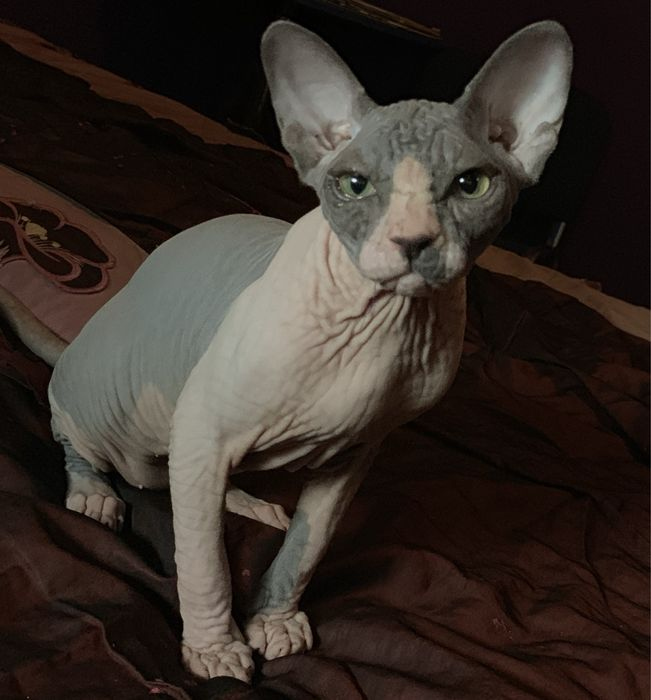

Top 3 predicted cat breeds:
Sphynx: 1.00
Abyssinian: 0.00
Domestic_Shorthair: 0.00


In [13]:
import torch
from PIL import Image
from IPython.display import Image as IPImage, display
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F

model_save_path = 'cat_breed_classifier_BEST.pth'
data_dir = 'data'

dataset = datasets.ImageFolder(data_dir)
num_classes = len(dataset.classes)

#Model
class CatBreedClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CatBreedClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128) 
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2) 
        
        self.fc1 = nn.Linear(256 * 28 * 28, 1024)
        self.dropout = nn.Dropout(0.4)  
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, num_classes)

    # przepływ danych przez sieć
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x) 
        x = self.fc3(x)
        return x

# Wczytywanie modelu
def load_model(model_path, num_classes):
    model = CatBreedClassifier(num_classes)  
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'),weights_only=True))
    model.eval()
    return model


# Predykcja dla pojedynczego zdjęcia
def predict_image(image_path, model, class_names):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        outputs = model(image)
        probabilities = torch.softmax(outputs, dim=1)[0]
        top3_prob, top3_classes = torch.topk(probabilities, 3)
    display(IPImage(filename=image_path),)
    results = [(class_names[idx], prob.item()) for idx, prob in zip(top3_classes, top3_prob)]
    return results


# Test predykcji
loaded_model = load_model(model_save_path, num_classes)
class_names = dataset.classes

image_path = 'sf.jpg'
predicted_breeds = predict_image(image_path, loaded_model, class_names)

print('Top 3 predicted cat breeds:')
for breed, prob in predicted_breeds:
    print(f'{breed}: {prob:.2f}')


## Analiza dokładności predykcji dla klas

In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from collections import defaultdict

model_save_path = 'mobilenetv2_finetuned.pth'  
data_dir = 'data'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)


test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size
_, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


def load_model(model_path, num_classes):
    model = models.mobilenet_v2(weights=None)  
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(0.3),
        torch.nn.Linear(model.last_channel, num_classes)
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

model = load_model(model_save_path, num_classes)

correct_per_class = defaultdict(int)
total_per_class = defaultdict(int)

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for true_label, pred_label in zip(labels, predicted):
            if true_label == pred_label:
                correct_per_class[true_label.item()] += 1
            total_per_class[true_label.item()] += 1

# OBLICZANIE DOKŁADNOŚCI DLA KAŻDEJ KLASY 
class_accuracies = {}
for idx, class_name in enumerate(class_names):
    correct = correct_per_class[idx]
    total = total_per_class[idx]
    acc = 100.0 * correct / total if total > 0 else 0.0
    class_accuracies[class_name] = acc

sorted_accuracies = sorted(class_accuracies.items(), key=lambda x: x[1])

print("Dokładność dla każdej klasy:")
for class_name, acc in sorted_accuracies:
    print(f"{class_name:25s}: {acc:.2f}%")

worst_class = sorted_accuracies[0]
print(f"Najgorzej rozpoznawana klasa: {worst_class[0]} ({worst_class[1]:.2f}% accuracy)")


/tmp/ipykernel_1440211/3846482198.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Dokładność dla każdej klasy:
Birman                   : 95.73%
British Shorthair        : 96.15%
Ragdoll                  : 96.57%
Egyptian Mau             : 96.72%
Bengal                   : 98.21%
Persian                  : 98.26%
Russian Blue             : 98.85%
Maine Coon               : 99.35%
Siamese                  : 99.37%
Abyssinian               : 99.38%
Bombay                   : 99.43%
Sphynx                   : 100.00%
Najgorzej rozpoznawana klasa: Birman (95.73% accuracy)


## TorchScript -> Aplikacja mobilna

In [4]:
import torch
from torchvision import models

pth_model_path = 'mobilenetv2_finetuned.pth'
pt_model_path = 'catmobilenetv2.pt'
num_classes = 12

#  ODTWORZENIE STRUKTURY MODELU 
model = models.mobilenet_v2(weights=None)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.3),
    torch.nn.Linear(model.last_channel, num_classes)
)

state_dict = torch.load(pth_model_path, map_location='cpu')
model.load_state_dict(state_dict)
model.eval()

example_input = torch.randn(1, 3, 224, 224)

traced_model = torch.jit.trace(model, example_input)
traced_model.save(pt_model_path)

/tmp/ipykernel_1440211/1735274938.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pth_model_path, map_location='cpu')
